In [1]:
import os
from glob import glob
import hashlib
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from copy import deepcopy
import ipynbname
import matplotlib.pyplot as plt
import shap
from datetime import datetime
import re

# Constants
EXPERIMENT_NAME = "nursing_home"
DATA_PATH = f"..{os.sep}data{os.sep}"

In [2]:
current_time = datetime.now()
print("Current time is:",current_time)

nb_fname = ipynbname.name()
print("File:",nb_fname)

experiment_number = int(re.findall(r'\d+', nb_fname)[0])
print(f"Experiment Number: {experiment_number}")  # Output: 01

Current time is: 2024-12-05 21:51:29.249729
File: machine_learning_experiment01
Experiment Number: 1


In [3]:
# Function to generate a consistent hash number for a given file name
def generate_hash_number(file_name):
    """
    Generates a consistent hash number based on the file name.
    
    Args:
        file_name (str): The file name to hash.
    
    Returns:
        int: A 32-bit hash number.
    """
    # Create an MD5 hash object
    hash_obj = hashlib.md5()
    
    # Update the hash object with the file name, encoded to bytes
    hash_obj.update(file_name.encode())

    # Convert the hash to an integer and ensure the range fits 32-bit
    return int(hash_obj.hexdigest(), 16) % (2**32)

# Generate experiment seed from experiment name
initial_seed = generate_hash_number(EXPERIMENT_NAME)
print(f"Experiment Name: {EXPERIMENT_NAME}, Initial Seed: {initial_seed}")

Experiment Name: nursing_home, Initial Seed: 127573839


In [4]:
# Set the seed for reproducibility
np.random.seed(initial_seed)

# Generate a list of 5 random integers in the range of 32-bit integers
random_integers_list = np.random.randint(low=0, high=2**31 - 1, size=10).tolist()
print("Random Integers List:", random_integers_list)
seed = random_integers_list[experiment_number-1]
# Load clinical microbiome data
df_path = glob(f'{DATA_PATH}*clinical_microbiome_df*')[0]
print(f"Data File Path: {df_path}")

clinical_microbiome_df = pd.read_csv(df_path)
print("Clinical Microbiome Data Loaded.")

# Display value counts for the 'Alzheimers' column
alzheimers_counts = clinical_microbiome_df['Alzheimers'].value_counts()
alzheimers_counts_normalized = clinical_microbiome_df['Alzheimers'].value_counts(normalize=True)

print("Alzheimers Counts:\n", alzheimers_counts)
print("Normalized Alzheimers Counts:\n", alzheimers_counts_normalized)
print(f"Seed in this experiment: {seed}")

Random Integers List: [315491657, 135304577, 1572185508, 1029933563, 1950160822, 563269619, 1573902777, 513873336, 442822283, 1770168448]
Data File Path: ../data/clinical_microbiome_df.csv
Clinical Microbiome Data Loaded.
Alzheimers Counts:
 Alzheimers
0.0    225
1.0    110
Name: count, dtype: int64
Normalized Alzheimers Counts:
 Alzheimers
0.0    0.671642
1.0    0.328358
Name: proportion, dtype: float64
Seed in this experiment: 315491657


In [5]:
clinical_microbiome_df["Dementia Other"].value_counts()

Dementia Other
0    335
Name: count, dtype: int64

In [6]:
clinical_microbiome_df = clinical_microbiome_df[clinical_microbiome_df["Dementia Other"] != 1]
# Display value counts for the 'Alzheimers' column
alzheimers_counts = clinical_microbiome_df['Alzheimers'].value_counts()
alzheimers_counts_normalized = clinical_microbiome_df['Alzheimers'].value_counts(normalize=True)
print("Alzheimers Counts:\n", alzheimers_counts)
print("Normalized Alzheimers Counts:\n", alzheimers_counts_normalized)

Alzheimers Counts:
 Alzheimers
0.0    225
1.0    110
Name: count, dtype: int64
Normalized Alzheimers Counts:
 Alzheimers
0.0    0.671642
1.0    0.328358
Name: proportion, dtype: float64


In [7]:
clinical_summaries_df = pd.read_csv(glob(f"..{os.sep}data{os.sep}clinical_summaries_df*")[0])
clinical_summaries_df

,Feature,Description,Group Characteristics,Summary
0,Sample ID,Unique identifier for biological or clinical s...,Study Identification,### Clinical Feature Summary\n\n#### Feature: ...
1,study_id,Identifier for the specific study or research ...,Study Identification,"### Clinical Feature Definitions, Scope, and R..."
2,day,Day of data collection or relevant event.,Temporal Information,### Clinical Feature Summary for Alzheimer's D...
3,Date Sample,Date when the sample was collected.,Temporal Information,### Clinical Feature Summary\n\n#### Feature: ...
4,age,Age of the participant.,Demographic Information,### Clinical Feature Summary: Age\n\n**Definit...
...,...,...,...,...
98,Severe Liver disease,Advanced liver disease diagnosis.,Hepatic Condition,### Clinical Feature: Severe Liver Disease\n\n...
99,ostomy,Presence of an ostomy.,Surgical History,### Clinical Feature: Ostomy\n\n**Definition:*...
100,Alzheimers,Diagnosis of Alzheimer’s disease.,Neurological Condition,### Clinical Feature Summary: Alzheimer's Dise...
101,Dementia Other,Other forms of dementia.,Neurological Condition,### Clinical Feature: Dementia Other\n\n**Defi...


In [8]:
clinical_summaries_df['Feature'].tolist()[:5]

['Sample ID', 'study_id', 'day', 'Date Sample', 'age']

In [9]:
clinical_summaries_df[['Feature']][clinical_summaries_df['Feature'].str.startswith(('c', 'C'))]

,Feature
10,clinical_frailty_scale
16,cholinesterase inhibitors
17,Calcium-channel blockers
58,Calcium Channel Modulators
59,Carbonic Anhydrase Inhibitor
60,Carboxamides
71,Chemotherapy Medication
81,COPD
86,Congestive heart failure
88,Cerebrovascular disease: CVA with mild or no r...


In [10]:
bacteria_df = pd.read_csv(glob(f"..{os.sep}data{os.sep}bacteria_df*")[0])
bacteria_df.species_name.tolist()[:5]

['Faecalibacterium_prausnitzii',
 'Fusicatenibacter_saccharivorans',
 'Eubacterium_siraeum',
 'Gemmiger_formicilis',
 'Eubacterium_rectale']

In [11]:
set(bacteria_df.species_name.tolist()[:5])

{'Eubacterium_rectale',
 'Eubacterium_siraeum',
 'Faecalibacterium_prausnitzii',
 'Fusicatenibacter_saccharivorans',
 'Gemmiger_formicilis'}

In [12]:
clinical_microbiome_df["Dementia Other"].value_counts()

Dementia Other
0    335
Name: count, dtype: int64

In [13]:
import os
from math import ceil
from pynvml import nvmlInit, nvmlDeviceGetCount

# Function to get the number of GPUs available
def get_num_gpus():
    try:
        nvmlInit()
        return nvmlDeviceGetCount()
    except Exception as e:
        print(f"Error accessing NVML: {e}")
        return 0

# Function to list all .ipynb files in the current directory
def get_notebook_files():
    return [f for f in os.listdir('.') if f.endswith('.ipynb')]

# Function to evenly distribute files across GPUs
def distribute_files_evenly(files, num_gpus):
    """
    Distributes files evenly across all available GPUs.
    
    Args:
        files (list): List of file names to distribute.
        num_gpus (int): Number of GPUs available.
        
    Returns:
        dict: Distribution of files per GPU.
    """
    distribution = {f"cuda:{i}": [] for i in range(num_gpus)}
    for idx, file in enumerate(files):
        # Assign each file to a GPU in round-robin fashion
        gpu_id = idx % num_gpus
        distribution[f"cuda:{gpu_id}"].append(file)
    return distribution

# Function to get GPU ID for a specific notebook file
def get_gpu_for_file(nb_fname, file_distribution):
    """
    Finds the GPU ID for a given notebook file based on the distribution.
    
    Args:
        nb_fname (str): Notebook file name to find the GPU for.
        file_distribution (dict): Distribution of files per GPU.
    
    Returns:
        str: GPU ID (e.g., "cuda:0") or "Unassigned" if the file is not found.
    """
    for gpu, files in file_distribution.items():
        if nb_fname in files:
            return gpu
    return "cpu"

# Main logic for the notebook
def assign_notebooks_to_gpus():
    # Get the number of GPUs
    num_gpus = get_num_gpus()
    if num_gpus == 0:
        print("No GPUs available. Using CPU for all tasks.")
        return {"cpu": get_notebook_files()}
    
    # Get the list of .ipynb files
    notebook_files = get_notebook_files()
    if not notebook_files:
        print("No .ipynb files found in the current directory.")
        return {}
    
    # Evenly distribute files across GPUs
    file_distribution = distribute_files_evenly(notebook_files, num_gpus)
    
    # Display the distribution in the notebook
    for gpu, files in file_distribution.items():
        print(f"{gpu}: {files}")
    
    return file_distribution

# Run the assignment logic
file_distribution = assign_notebooks_to_gpus()

# Get the GPU ID for the specific notebook file
device = get_gpu_for_file(f"{nb_fname}.ipynb", file_distribution)

print(f"Initial seed: {initial_seed}")
print(f"Random Integers List: {random_integers_list}")
# Print the result
print(f"Notebook '{nb_fname}.ipynb' is assigned to device: {device} with seed {seed}.")

cuda:0: ['machine_learning_experiment03.ipynb', 'machine_learning_experiment06.ipynb', 'machine_learning_experiment08.ipynb']
cuda:1: ['machine_learning_experiment09.ipynb', 'machine_learning_experiment07.ipynb', 'machine_learning_experiment10.ipynb']
cuda:2: ['machine_learning_experiment02.ipynb', 'machine_learning_experiment04.ipynb']
cuda:3: ['machine_learning_experiment05.ipynb', 'machine_learning_experiment01.ipynb']
Initial seed: 127573839
Random Integers List: [315491657, 135304577, 1572185508, 1029933563, 1950160822, 563269619, 1573902777, 513873336, 442822283, 1770168448]
Notebook 'machine_learning_experiment01.ipynb' is assigned to device: cuda:3 with seed 315491657.


Experiment number: 1 | Seed number: 315491657
No overlap Study ID found.
No overlap Sample ID found.


[I 2024-12-05 21:51:30,021] A new study created in memory with name: no-name-197e4d18-acc9-4b4f-a757-09ee8de2ceba


Seed in the model 315491657 on Device cuda:3


[I 2024-12-05 21:51:30,609] Trial 0 finished with value: 0.7092713072812575 and parameters: {'threshold': 'mean', 'max_features': 730, 'norm_order': 2, 'learning_rate': 0.22784462951868784, 'max_depth': 22, 'min_child_weight': 4, 'subsample': 0.8933027395291244, 'colsample_bytree': 0.7141781976236643, 'gamma': 2.4005160139028456, 'reg_alpha': 9.635155887531152, 'reg_lambda': 1.9995348138898184, 'n_estimators': 115}. Best is trial 0 with value: 0.7092713072812575.


Seed in the model 315491657 on Device cuda:3


[I 2024-12-05 21:51:31,110] Trial 1 finished with value: 0.688058748403576 and parameters: {'threshold': '1.5*mean', 'max_features': 1006, 'norm_order': 1, 'learning_rate': 0.17676351715053212, 'max_depth': 4, 'min_child_weight': 1, 'subsample': 0.6083677945683332, 'colsample_bytree': 0.615847622074301, 'gamma': 6.040195753743694, 'reg_alpha': 6.4682910507980775, 'reg_lambda': 0.9037492807019143, 'n_estimators': 256}. Best is trial 0 with value: 0.7092713072812575.


Seed in the model 315491657 on Device cuda:3


[I 2024-12-05 21:51:31,526] Trial 2 finished with value: 0.6847902097902098 and parameters: {'threshold': 'very_low', 'max_features': 650, 'norm_order': 2, 'learning_rate': 0.2949799263026363, 'max_depth': 24, 'min_child_weight': 4, 'subsample': 0.738709717809245, 'colsample_bytree': 0.8592941039807216, 'gamma': 3.2985339560702287, 'reg_alpha': 5.538540724631281, 'reg_lambda': 6.0840884248471845, 'n_estimators': 104}. Best is trial 0 with value: 0.7092713072812575.


Seed in the model 315491657 on Device cuda:3


[I 2024-12-05 21:51:31,931] Trial 3 finished with value: 0.6547651359998684 and parameters: {'threshold': 'mean', 'max_features': 44, 'norm_order': 1, 'learning_rate': 0.15203063747610884, 'max_depth': 9, 'min_child_weight': 5, 'subsample': 0.5850993899866203, 'colsample_bytree': 0.7419610548830455, 'gamma': 9.291046597929022, 'reg_alpha': 6.7417072192956065, 'reg_lambda': 8.00695945717935, 'n_estimators': 233}. Best is trial 0 with value: 0.7092713072812575.


Seed in the model 315491657 on Device cuda:3


[I 2024-12-05 21:51:32,324] Trial 4 finished with value: 0.7137042062415198 and parameters: {'threshold': 'very_low', 'max_features': 197, 'norm_order': 1, 'learning_rate': 0.13780801866929854, 'max_depth': 7, 'min_child_weight': 2, 'subsample': 0.9744882819685514, 'colsample_bytree': 0.8110590718449235, 'gamma': 7.252388949961448, 'reg_alpha': 2.320638700209452, 'reg_lambda': 8.188918845741354, 'n_estimators': 93}. Best is trial 4 with value: 0.7137042062415198.


Seed in the model 315491657 on Device cuda:3


[I 2024-12-05 21:51:32,970] Trial 5 finished with value: 0.7395962913204293 and parameters: {'threshold': 'very_low', 'max_features': 769, 'norm_order': 2, 'learning_rate': 0.057121437827271714, 'max_depth': 13, 'min_child_weight': 5, 'subsample': 0.8557277409437319, 'colsample_bytree': 0.5300472383632331, 'gamma': 5.642283303245628, 'reg_alpha': 0.7199907542226935, 'reg_lambda': 8.020313096301807, 'n_estimators': 160}. Best is trial 5 with value: 0.7395962913204293.


Seed in the model 315491657 on Device cuda:3


[I 2024-12-05 21:51:33,425] Trial 6 finished with value: 0.7738418669453152 and parameters: {'threshold': 'mean', 'max_features': 188, 'norm_order': 2, 'learning_rate': 0.049909425853960736, 'max_depth': 12, 'min_child_weight': 1, 'subsample': 0.8446444688493939, 'colsample_bytree': 0.7685191742076549, 'gamma': 4.38909333825313, 'reg_alpha': 6.704644126876321, 'reg_lambda': 0.06525053233612632, 'n_estimators': 169}. Best is trial 6 with value: 0.7738418669453152.


Seed in the model 315491657 on Device cuda:3


[I 2024-12-05 21:51:33,833] Trial 7 finished with value: 0.7797070359514606 and parameters: {'threshold': 'median', 'max_features': 70, 'norm_order': 2, 'learning_rate': 0.2263141324759608, 'max_depth': 5, 'min_child_weight': 2, 'subsample': 0.9806912844460409, 'colsample_bytree': 0.6319174298006374, 'gamma': 4.006207963822272, 'reg_alpha': 1.3051378211620446, 'reg_lambda': 8.76915611051725, 'n_estimators': 146}. Best is trial 7 with value: 0.7797070359514606.


Seed in the model 315491657 on Device cuda:3


[I 2024-12-05 21:51:34,346] Trial 8 finished with value: 0.8365586195774876 and parameters: {'threshold': 'mean', 'max_features': 740, 'norm_order': 2, 'learning_rate': 0.15791951051064648, 'max_depth': 29, 'min_child_weight': 3, 'subsample': 0.6404379998238797, 'colsample_bytree': 0.5151109544231391, 'gamma': 1.1029859192719316, 'reg_alpha': 1.765036968347613, 'reg_lambda': 7.730525855860332, 'n_estimators': 137}. Best is trial 8 with value: 0.8365586195774876.


Seed in the model 315491657 on Device cuda:3


[I 2024-12-05 21:51:34,690] Trial 9 finished with value: 0.7053466814979606 and parameters: {'threshold': 'very_low', 'max_features': 162, 'norm_order': 1, 'learning_rate': 0.37239324729305107, 'max_depth': 24, 'min_child_weight': 6, 'subsample': 0.5210180146051819, 'colsample_bytree': 0.8772151712274888, 'gamma': 4.573393442953327, 'reg_alpha': 0.7414218689220042, 'reg_lambda': 3.456933915089385, 'n_estimators': 89}. Best is trial 8 with value: 0.8365586195774876.


Seed in the model 315491657 on Device cuda:3


[I 2024-12-05 21:51:35,148] Trial 10 finished with value: 0.7717868338557995 and parameters: {'threshold': '0.5*mean', 'max_features': 448, 'norm_order': 2, 'learning_rate': 0.46516625185067395, 'max_depth': 30, 'min_child_weight': 9, 'subsample': 0.7170770555961461, 'colsample_bytree': 0.9492769237998882, 'gamma': 0.12266963308148249, 'reg_alpha': 3.397732423218331, 'reg_lambda': 6.071564648070794, 'n_estimators': 54}. Best is trial 8 with value: 0.8365586195774876.


Seed in the model 315491657 on Device cuda:3


[I 2024-12-05 21:51:35,865] Trial 11 finished with value: 0.801913875598086 and parameters: {'threshold': 'median', 'max_features': 444, 'norm_order': 2, 'learning_rate': 0.29937717633678096, 'max_depth': 18, 'min_child_weight': 3, 'subsample': 0.6428215546926339, 'colsample_bytree': 0.5114296933612168, 'gamma': 0.648165687907456, 'reg_alpha': 3.039953504023509, 'reg_lambda': 9.764270638780781, 'n_estimators': 208}. Best is trial 8 with value: 0.8365586195774876.


Seed in the model 315491657 on Device cuda:3


[I 2024-12-05 21:51:36,781] Trial 12 finished with value: 0.7826411345124615 and parameters: {'threshold': 'median', 'max_features': 436, 'norm_order': 2, 'learning_rate': 0.3337394877707698, 'max_depth': 18, 'min_child_weight': 7, 'subsample': 0.6617410571541376, 'colsample_bytree': 0.5114384949575571, 'gamma': 0.041680662833021964, 'reg_alpha': 3.604872589543238, 'reg_lambda': 9.649378907511835, 'n_estimators': 213}. Best is trial 8 with value: 0.8365586195774876.


Seed in the model 315491657 on Device cuda:3


[I 2024-12-05 21:51:37,367] Trial 13 finished with value: 0.7740856844305121 and parameters: {'threshold': 'median', 'max_features': 913, 'norm_order': 2, 'learning_rate': 0.4140747652947368, 'max_depth': 27, 'min_child_weight': 3, 'subsample': 0.6597233399629503, 'colsample_bytree': 0.597551100038696, 'gamma': 1.9363706029425614, 'reg_alpha': 3.810073810824054, 'reg_lambda': 9.881798337731798, 'n_estimators': 211}. Best is trial 8 with value: 0.8365586195774876.


Seed in the model 315491657 on Device cuda:3


[I 2024-12-05 21:51:38,208] Trial 14 finished with value: 0.8131794131794131 and parameters: {'threshold': '0.5*mean', 'max_features': 569, 'norm_order': 2, 'learning_rate': 0.2958975405040072, 'max_depth': 19, 'min_child_weight': 3, 'subsample': 0.5032898567060975, 'colsample_bytree': 0.5613801419928828, 'gamma': 1.4958546930407624, 'reg_alpha': 2.1453095008152685, 'reg_lambda': 6.418209549984994, 'n_estimators': 287}. Best is trial 8 with value: 0.8365586195774876.


Seed in the model 315491657 on Device cuda:3


[I 2024-12-05 21:51:39,083] Trial 15 finished with value: 0.7444059696656744 and parameters: {'threshold': '0.5*mean', 'max_features': 591, 'norm_order': 2, 'learning_rate': 0.09496998499194437, 'max_depth': 30, 'min_child_weight': 7, 'subsample': 0.5010941486621372, 'colsample_bytree': 0.6799147322448182, 'gamma': 1.9381065068879688, 'reg_alpha': 1.9866467118325728, 'reg_lambda': 6.177325146615713, 'n_estimators': 295}. Best is trial 8 with value: 0.8365586195774876.


Seed in the model 315491657 on Device cuda:3


[I 2024-12-05 21:51:39,622] Trial 16 finished with value: 0.7129304743339832 and parameters: {'threshold': '0.5*mean', 'max_features': 842, 'norm_order': 2, 'learning_rate': 0.2564138067813152, 'max_depth': 21, 'min_child_weight': 10, 'subsample': 0.557212755748917, 'colsample_bytree': 0.5549968745298445, 'gamma': 1.2397175193966423, 'reg_alpha': 0.14662466113158557, 'reg_lambda': 4.504940293996604, 'n_estimators': 282}. Best is trial 8 with value: 0.8365586195774876.


Seed in the model 315491657 on Device cuda:3


[I 2024-12-05 21:51:40,179] Trial 17 finished with value: 0.7975848712690818 and parameters: {'threshold': '1.5*mean', 'max_features': 330, 'norm_order': 1, 'learning_rate': 0.18982390350496217, 'max_depth': 15, 'min_child_weight': 3, 'subsample': 0.798621590221347, 'colsample_bytree': 0.6582559241882036, 'gamma': 2.7509081063805745, 'reg_alpha': 5.068568492802055, 'reg_lambda': 7.008856825145278, 'n_estimators': 135}. Best is trial 8 with value: 0.8365586195774876.


Seed in the model 315491657 on Device cuda:3


[I 2024-12-05 21:51:41,117] Trial 18 finished with value: 0.7544663391657926 and parameters: {'threshold': '0.5*mean', 'max_features': 579, 'norm_order': 2, 'learning_rate': 0.014963595668834928, 'max_depth': 27, 'min_child_weight': 4, 'subsample': 0.5486202776548056, 'colsample_bytree': 0.5919550388917934, 'gamma': 1.3207076119858578, 'reg_alpha': 2.2463526917149137, 'reg_lambda': 4.733632468034867, 'n_estimators': 186}. Best is trial 8 with value: 0.8365586195774876.


Seed in the model 315491657 on Device cuda:3


[I 2024-12-05 21:51:41,985] Trial 19 finished with value: 0.6937330966869507 and parameters: {'threshold': 'mean', 'max_features': 705, 'norm_order': 2, 'learning_rate': 0.11045987205398142, 'max_depth': 20, 'min_child_weight': 2, 'subsample': 0.712667607714312, 'colsample_bytree': 0.5724072974600245, 'gamma': 3.563144483751107, 'reg_alpha': 9.234561980844767, 'reg_lambda': 6.975327985130782, 'n_estimators': 257}. Best is trial 8 with value: 0.8365586195774876.


Seed in the model 315491657 on Device cuda:3


[I 2024-12-05 21:51:42,578] Trial 20 finished with value: 0.656719800559039 and parameters: {'threshold': 'mean', 'max_features': 867, 'norm_order': 1, 'learning_rate': 0.49659994846449473, 'max_depth': 26, 'min_child_weight': 6, 'subsample': 0.5891617932061937, 'colsample_bytree': 0.9865372654563369, 'gamma': 7.339544834326553, 'reg_alpha': 4.416384174342044, 'reg_lambda': 3.4081535287816638, 'n_estimators': 182}. Best is trial 8 with value: 0.8365586195774876.


Seed in the model 315491657 on Device cuda:3


[I 2024-12-05 21:51:43,627] Trial 21 finished with value: 0.8336988137116056 and parameters: {'threshold': 'median', 'max_features': 467, 'norm_order': 2, 'learning_rate': 0.2972738445825286, 'max_depth': 17, 'min_child_weight': 3, 'subsample': 0.6485250739431524, 'colsample_bytree': 0.5034537398078015, 'gamma': 1.0116405173305734, 'reg_alpha': 2.848572075786409, 'reg_lambda': 8.671458339832505, 'n_estimators': 251}. Best is trial 8 with value: 0.8365586195774876.


Seed in the model 315491657 on Device cuda:3


[I 2024-12-05 21:51:44,731] Trial 22 finished with value: 0.8345149474181732 and parameters: {'threshold': '0.5*mean', 'max_features': 345, 'norm_order': 2, 'learning_rate': 0.2880306356911103, 'max_depth': 15, 'min_child_weight': 3, 'subsample': 0.6417544269385352, 'colsample_bytree': 0.5502406727887553, 'gamma': 1.080876443253842, 'reg_alpha': 1.7613221943580244, 'reg_lambda': 7.242970176396885, 'n_estimators': 271}. Best is trial 8 with value: 0.8365586195774876.


Seed in the model 315491657 on Device cuda:3


[I 2024-12-05 21:51:45,756] Trial 23 finished with value: 0.8180088200341905 and parameters: {'threshold': 'median', 'max_features': 339, 'norm_order': 2, 'learning_rate': 0.3659882262104998, 'max_depth': 15, 'min_child_weight': 1, 'subsample': 0.6834698776090391, 'colsample_bytree': 0.5016289869682489, 'gamma': 0.7847688687820726, 'reg_alpha': 1.528841108180018, 'reg_lambda': 8.680197324459472, 'n_estimators': 253}. Best is trial 8 with value: 0.8365586195774876.


Seed in the model 315491657 on Device cuda:3


[I 2024-12-05 21:51:46,925] Trial 24 finished with value: 0.8221279571854284 and parameters: {'threshold': '1.5*mean', 'max_features': 315, 'norm_order': 2, 'learning_rate': 0.2539222193233141, 'max_depth': 13, 'min_child_weight': 4, 'subsample': 0.7819429904364179, 'colsample_bytree': 0.5353602900008508, 'gamma': 2.666867654147331, 'reg_alpha': 2.6362309333544127, 'reg_lambda': 7.086079338415763, 'n_estimators': 235}. Best is trial 8 with value: 0.8365586195774876.


Seed in the model 315491657 on Device cuda:3


[I 2024-12-05 21:51:48,412] Trial 25 finished with value: 0.8636696747364744 and parameters: {'threshold': '0.5*mean', 'max_features': 502, 'norm_order': 2, 'learning_rate': 0.2082824592249463, 'max_depth': 10, 'min_child_weight': 2, 'subsample': 0.6449940772737914, 'colsample_bytree': 0.6604422275126087, 'gamma': 0.6671324035314918, 'reg_alpha': 1.140454184426351, 'reg_lambda': 9.093986118989607, 'n_estimators': 272}. Best is trial 25 with value: 0.8636696747364744.


Seed in the model 315491657 on Device cuda:3


[I 2024-12-05 21:51:49,972] Trial 26 finished with value: 0.8537859868621682 and parameters: {'threshold': '0.5*mean', 'max_features': 267, 'norm_order': 2, 'learning_rate': 0.2047001009232398, 'max_depth': 10, 'min_child_weight': 2, 'subsample': 0.6170320860686784, 'colsample_bytree': 0.6639041929714562, 'gamma': 2.057645696277393, 'reg_alpha': 0.08847733467405772, 'reg_lambda': 7.4253791935266245, 'n_estimators': 271}. Best is trial 25 with value: 0.8636696747364744.


Seed in the model 315491657 on Device cuda:3


[I 2024-12-05 21:51:51,569] Trial 27 finished with value: 0.8638482038162243 and parameters: {'threshold': '0.5*mean', 'max_features': 648, 'norm_order': 2, 'learning_rate': 0.19791973765912005, 'max_depth': 10, 'min_child_weight': 2, 'subsample': 0.6038182957076357, 'colsample_bytree': 0.682493175554585, 'gamma': 0.012424595532965155, 'reg_alpha': 0.05160250437566938, 'reg_lambda': 5.410272300646185, 'n_estimators': 300}. Best is trial 27 with value: 0.8638482038162243.


Seed in the model 315491657 on Device cuda:3


[I 2024-12-05 21:51:54,844] Trial 28 finished with value: 0.8702992776057791 and parameters: {'threshold': '0.5*mean', 'max_features': 256, 'norm_order': 2, 'learning_rate': 0.209040203261199, 'max_depth': 9, 'min_child_weight': 2, 'subsample': 0.6115593974716584, 'colsample_bytree': 0.6800122436393444, 'gamma': 0.11401393344835165, 'reg_alpha': 0.7600411842250061, 'reg_lambda': 5.447751982247263, 'n_estimators': 276}. Best is trial 28 with value: 0.8702992776057791.


Seed in the model 315491657 on Device cuda:3


[I 2024-12-05 21:51:58,763] Trial 29 finished with value: 0.8781937017231135 and parameters: {'threshold': '0.5*mean', 'max_features': 517, 'norm_order': 2, 'learning_rate': 0.23505364522969058, 'max_depth': 7, 'min_child_weight': 1, 'subsample': 0.6940227453668993, 'colsample_bytree': 0.7179705288257805, 'gamma': 0.043149227720401306, 'reg_alpha': 0.8089252769849158, 'reg_lambda': 3.5810314095871005, 'n_estimators': 298}. Best is trial 29 with value: 0.8781937017231135.


Seed in the model 315491657 on Device cuda:3


[I 2024-12-05 21:52:02,116] Trial 30 finished with value: 0.8773669467787114 and parameters: {'threshold': '0.5*mean', 'max_features': 653, 'norm_order': 2, 'learning_rate': 0.2421330608289811, 'max_depth': 7, 'min_child_weight': 1, 'subsample': 0.7015484171302633, 'colsample_bytree': 0.7031539251409643, 'gamma': 0.1327454101857061, 'reg_alpha': 0.0482743779519903, 'reg_lambda': 3.6389109084845024, 'n_estimators': 286}. Best is trial 29 with value: 0.8781937017231135.


Seed in the model 315491657 on Device cuda:3


[I 2024-12-05 21:52:06,364] Trial 31 finished with value: 0.8757023277147117 and parameters: {'threshold': '0.5*mean', 'max_features': 660, 'norm_order': 2, 'learning_rate': 0.23720910900230546, 'max_depth': 6, 'min_child_weight': 1, 'subsample': 0.6937405701119088, 'colsample_bytree': 0.7078247509600116, 'gamma': 0.13907365267677407, 'reg_alpha': 0.09029295373599446, 'reg_lambda': 3.701764992811821, 'n_estimators': 286}. Best is trial 29 with value: 0.8781937017231135.


Seed in the model 315491657 on Device cuda:3


[I 2024-12-05 21:52:09,398] Trial 32 finished with value: 0.8762147793726741 and parameters: {'threshold': '0.5*mean', 'max_features': 642, 'norm_order': 2, 'learning_rate': 0.253494365058186, 'max_depth': 3, 'min_child_weight': 1, 'subsample': 0.7012344538516534, 'colsample_bytree': 0.7183500040062969, 'gamma': 0.3388179080530672, 'reg_alpha': 0.6903799769260143, 'reg_lambda': 2.7468552119577625, 'n_estimators': 238}. Best is trial 29 with value: 0.8781937017231135.


Seed in the model 315491657 on Device cuda:3


[I 2024-12-05 21:52:12,534] Trial 33 finished with value: 0.826939669476339 and parameters: {'threshold': '0.5*mean', 'max_features': 644, 'norm_order': 2, 'learning_rate': 0.261023241788926, 'max_depth': 3, 'min_child_weight': 1, 'subsample': 0.7577604717827973, 'colsample_bytree': 0.7216676763615294, 'gamma': 2.9634727838083, 'reg_alpha': 0.7362751206220834, 'reg_lambda': 2.2831288253860818, 'n_estimators': 229}. Best is trial 29 with value: 0.8781937017231135.


Seed in the model 315491657 on Device cuda:3


[I 2024-12-05 21:52:15,623] Trial 34 finished with value: 0.678941798941799 and parameters: {'threshold': '0.5*mean', 'max_features': 698, 'norm_order': 2, 'learning_rate': 0.24668784640008992, 'max_depth': 6, 'min_child_weight': 1, 'subsample': 0.6907289092550123, 'colsample_bytree': 0.7691909274422212, 'gamma': 9.283960097384483, 'reg_alpha': 7.971800892363802, 'reg_lambda': 2.1189245943447927, 'n_estimators': 299}. Best is trial 29 with value: 0.8781937017231135.


Seed in the model 315491657 on Device cuda:3


[I 2024-12-05 21:52:19,012] Trial 35 finished with value: 0.8303820473311999 and parameters: {'threshold': '0.5*mean', 'max_features': 534, 'norm_order': 1, 'learning_rate': 0.34830739905930314, 'max_depth': 7, 'min_child_weight': 1, 'subsample': 0.7516438557734554, 'colsample_bytree': 0.7186483895457186, 'gamma': 1.800914376783148, 'reg_alpha': 1.1011998191280377, 'reg_lambda': 3.1456964745155553, 'n_estimators': 244}. Best is trial 29 with value: 0.8781937017231135.


Seed in the model 315491657 on Device cuda:3


[I 2024-12-05 21:52:22,661] Trial 36 finished with value: 0.8260912931654804 and parameters: {'threshold': '0.5*mean', 'max_features': 798, 'norm_order': 2, 'learning_rate': 0.2321441600883407, 'max_depth': 3, 'min_child_weight': 1, 'subsample': 0.7199155474977055, 'colsample_bytree': 0.8042065204334689, 'gamma': 0.568453381650766, 'reg_alpha': 5.885852696876691, 'reg_lambda': 4.191595837111825, 'n_estimators': 262}. Best is trial 29 with value: 0.8781937017231135.


Seed in the model 315491657 on Device cuda:3


[I 2024-12-05 21:52:26,060] Trial 37 finished with value: 0.8212782288056465 and parameters: {'threshold': '1.5*mean', 'max_features': 1006, 'norm_order': 2, 'learning_rate': 0.16899442183383975, 'max_depth': 5, 'min_child_weight': 1, 'subsample': 0.7870607178741035, 'colsample_bytree': 0.7476659917065135, 'gamma': 6.820030523140203, 'reg_alpha': 0.1147752556268465, 'reg_lambda': 1.5730049376244781, 'n_estimators': 286}. Best is trial 29 with value: 0.8781937017231135.


Seed in the model 315491657 on Device cuda:3


[I 2024-12-05 21:52:29,795] Trial 38 finished with value: 0.7476190476190476 and parameters: {'threshold': '0.5*mean', 'max_features': 939, 'norm_order': 2, 'learning_rate': 0.13489036809458754, 'max_depth': 8, 'min_child_weight': 1, 'subsample': 0.8152574022800567, 'colsample_bytree': 0.7938552898095526, 'gamma': 8.293174584866954, 'reg_alpha': 0.6159571596666974, 'reg_lambda': 2.8723978583201175, 'n_estimators': 228}. Best is trial 29 with value: 0.8781937017231135.


Seed in the model 315491657 on Device cuda:3


[I 2024-12-05 21:52:33,615] Trial 39 finished with value: 0.8103033982815404 and parameters: {'threshold': 'very_low', 'max_features': 622, 'norm_order': 1, 'learning_rate': 0.327217321883003, 'max_depth': 5, 'min_child_weight': 2, 'subsample': 0.6886709293654704, 'colsample_bytree': 0.8454650221995167, 'gamma': 2.294658434408597, 'reg_alpha': 1.3132610241387055, 'reg_lambda': 3.9701267253587322, 'n_estimators': 199}. Best is trial 29 with value: 0.8781937017231135.


Seed in the model 315491657 on Device cuda:3


[I 2024-12-05 21:52:36,646] Trial 40 finished with value: 0.807017543859649 and parameters: {'threshold': '0.5*mean', 'max_features': 696, 'norm_order': 2, 'learning_rate': 0.2782945122038955, 'max_depth': 7, 'min_child_weight': 4, 'subsample': 0.8779575599423729, 'colsample_bytree': 0.7058564610312793, 'gamma': 5.967827944145837, 'reg_alpha': 0.500296515715555, 'reg_lambda': 1.021172171684218, 'n_estimators': 264}. Best is trial 29 with value: 0.8781937017231135.


Seed in the model 315491657 on Device cuda:3


[I 2024-12-05 21:52:40,340] Trial 41 finished with value: 0.8809067366226078 and parameters: {'threshold': '0.5*mean', 'max_features': 779, 'norm_order': 2, 'learning_rate': 0.2277801455575661, 'max_depth': 8, 'min_child_weight': 2, 'subsample': 0.727330296137974, 'colsample_bytree': 0.6388119293404557, 'gamma': 0.3017690912627953, 'reg_alpha': 0.9710772894961935, 'reg_lambda': 5.1763016389547785, 'n_estimators': 280}. Best is trial 41 with value: 0.8809067366226078.


Seed in the model 315491657 on Device cuda:3


[I 2024-12-05 21:52:43,850] Trial 42 finished with value: 0.8934731934731935 and parameters: {'threshold': '0.5*mean', 'max_features': 754, 'norm_order': 2, 'learning_rate': 0.23007652531681744, 'max_depth': 4, 'min_child_weight': 1, 'subsample': 0.7338696715310001, 'colsample_bytree': 0.6421042532580573, 'gamma': 0.5048001404278148, 'reg_alpha': 1.2540669635784139, 'reg_lambda': 2.7102258223661977, 'n_estimators': 287}. Best is trial 42 with value: 0.8934731934731935.


Seed in the model 315491657 on Device cuda:3


[I 2024-12-05 21:52:47,356] Trial 43 finished with value: 0.8540965207631874 and parameters: {'threshold': '0.5*mean', 'max_features': 759, 'norm_order': 2, 'learning_rate': 0.2204819460231712, 'max_depth': 4, 'min_child_weight': 2, 'subsample': 0.7362931517235793, 'colsample_bytree': 0.6355220522037468, 'gamma': 0.5341425070234529, 'reg_alpha': 1.5235185942264617, 'reg_lambda': 2.6686115188341075, 'n_estimators': 245}. Best is trial 42 with value: 0.8934731934731935.


Seed in the model 315491657 on Device cuda:3


[I 2024-12-05 21:52:50,507] Trial 44 finished with value: 0.8294106976213586 and parameters: {'threshold': 'very_low', 'max_features': 840, 'norm_order': 2, 'learning_rate': 0.1823458240024301, 'max_depth': 4, 'min_child_weight': 1, 'subsample': 0.771461805264786, 'colsample_bytree': 0.6241079933355748, 'gamma': 1.6113305873502817, 'reg_alpha': 1.0205913097322037, 'reg_lambda': 1.5853483182037424, 'n_estimators': 290}. Best is trial 42 with value: 0.8934731934731935.


Seed in the model 315491657 on Device cuda:3


[I 2024-12-05 21:52:54,093] Trial 45 finished with value: 0.8519863689355214 and parameters: {'threshold': '0.5*mean', 'max_features': 779, 'norm_order': 2, 'learning_rate': 0.2752845597425015, 'max_depth': 12, 'min_child_weight': 2, 'subsample': 0.7315036230235418, 'colsample_bytree': 0.7401022793561707, 'gamma': 0.371439757983306, 'reg_alpha': 2.372652972150563, 'reg_lambda': 5.116358669663299, 'n_estimators': 276}. Best is trial 42 with value: 0.8934731934731935.


Seed in the model 315491657 on Device cuda:3


[I 2024-12-05 21:52:56,862] Trial 46 finished with value: 0.8257713248638838 and parameters: {'threshold': '0.5*mean', 'max_features': 529, 'norm_order': 2, 'learning_rate': 0.3194987419564857, 'max_depth': 8, 'min_child_weight': 1, 'subsample': 0.8231621533241398, 'colsample_bytree': 0.6095388163264284, 'gamma': 4.9415100210450715, 'reg_alpha': 1.5796767357240604, 'reg_lambda': 2.7490720296416744, 'n_estimators': 263}. Best is trial 42 with value: 0.8934731934731935.


Seed in the model 315491657 on Device cuda:3


[I 2024-12-05 21:53:00,932] Trial 47 finished with value: 0.8163173315303132 and parameters: {'threshold': '0.5*mean', 'max_features': 896, 'norm_order': 2, 'learning_rate': 0.1436492915514517, 'max_depth': 3, 'min_child_weight': 2, 'subsample': 0.750868181679844, 'colsample_bytree': 0.7747544179363488, 'gamma': 0.996278792824514, 'reg_alpha': 3.256949981661845, 'reg_lambda': 4.212293693465291, 'n_estimators': 280}. Best is trial 42 with value: 0.8934731934731935.


Seed in the model 315491657 on Device cuda:3


[I 2024-12-05 21:53:05,050] Trial 48 finished with value: 0.8570516329137018 and parameters: {'threshold': 'mean', 'max_features': 719, 'norm_order': 2, 'learning_rate': 0.23316785640052817, 'max_depth': 6, 'min_child_weight': 1, 'subsample': 0.7083997833890646, 'colsample_bytree': 0.6404597951876306, 'gamma': 3.3622108358720624, 'reg_alpha': 0.49967036794663544, 'reg_lambda': 0.41149915673255766, 'n_estimators': 240}. Best is trial 42 with value: 0.8934731934731935.


Seed in the model 315491657 on Device cuda:3


[I 2024-12-05 21:53:08,165] Trial 49 finished with value: 0.7919837970365634 and parameters: {'threshold': '1.5*mean', 'max_features': 949, 'norm_order': 2, 'learning_rate': 0.17389974104713102, 'max_depth': 11, 'min_child_weight': 5, 'subsample': 0.6706789501099819, 'colsample_bytree': 0.6902706289589262, 'gamma': 1.3722968760927563, 'reg_alpha': 4.1817329626918225, 'reg_lambda': 3.701565873962849, 'n_estimators': 225}. Best is trial 42 with value: 0.8934731934731935.


Seed in the model 315491657 on Device cuda:3


[I 2024-12-05 21:53:11,778] Trial 50 finished with value: 0.8001535669412257 and parameters: {'threshold': '0.5*mean', 'max_features': 820, 'norm_order': 2, 'learning_rate': 0.39684898578553895, 'max_depth': 8, 'min_child_weight': 9, 'subsample': 0.9066398648179174, 'colsample_bytree': 0.8293099180786557, 'gamma': 0.47850643524083947, 'reg_alpha': 1.9624260369052926, 'reg_lambda': 2.4171427690801943, 'n_estimators': 300}. Best is trial 42 with value: 0.8934731934731935.


Seed in the model 315491657 on Device cuda:3


[I 2024-12-05 21:53:16,423] Trial 51 finished with value: 0.8822021116138764 and parameters: {'threshold': '0.5*mean', 'max_features': 674, 'norm_order': 2, 'learning_rate': 0.24101284724603056, 'max_depth': 6, 'min_child_weight': 1, 'subsample': 0.6916895237505183, 'colsample_bytree': 0.7227455097851561, 'gamma': 0.057532557991415684, 'reg_alpha': 0.4676040802403888, 'reg_lambda': 3.2624350457780023, 'n_estimators': 289}. Best is trial 42 with value: 0.8934731934731935.


Seed in the model 315491657 on Device cuda:3


[I 2024-12-05 21:53:20,422] Trial 52 finished with value: 0.8587732528908999 and parameters: {'threshold': '0.5*mean', 'max_features': 612, 'norm_order': 2, 'learning_rate': 0.27379413684953846, 'max_depth': 5, 'min_child_weight': 1, 'subsample': 0.6716705333881979, 'colsample_bytree': 0.7317035853346722, 'gamma': 0.8369301491227576, 'reg_alpha': 1.1245873151945731, 'reg_lambda': 1.7068270585862821, 'n_estimators': 288}. Best is trial 42 with value: 0.8934731934731935.


Seed in the model 315491657 on Device cuda:3


[I 2024-12-05 21:53:24,368] Trial 53 finished with value: 0.9110622710622711 and parameters: {'threshold': '0.5*mean', 'max_features': 559, 'norm_order': 2, 'learning_rate': 0.3129216931849526, 'max_depth': 4, 'min_child_weight': 1, 'subsample': 0.7049803815302474, 'colsample_bytree': 0.6962321539562432, 'gamma': 0.01857675627397261, 'reg_alpha': 0.46322755189723763, 'reg_lambda': 3.2291126086474446, 'n_estimators': 266}. Best is trial 53 with value: 0.9110622710622711.


Seed in the model 315491657 on Device cuda:3


[I 2024-12-05 21:53:28,368] Trial 54 finished with value: 0.8697880270207313 and parameters: {'threshold': '0.5*mean', 'max_features': 390, 'norm_order': 2, 'learning_rate': 0.22093750239777685, 'max_depth': 7, 'min_child_weight': 3, 'subsample': 0.7294154068733614, 'colsample_bytree': 0.6496620535859603, 'gamma': 1.4932042451372793, 'reg_alpha': 0.45677585199982196, 'reg_lambda': 3.2367056917235884, 'n_estimators': 267}. Best is trial 53 with value: 0.9110622710622711.


Seed in the model 315491657 on Device cuda:3


[I 2024-12-05 21:53:32,590] Trial 55 finished with value: 0.8208356139390621 and parameters: {'threshold': 'very_low', 'max_features': 559, 'norm_order': 2, 'learning_rate': 0.3139837039827225, 'max_depth': 9, 'min_child_weight': 2, 'subsample': 0.6261633804847747, 'colsample_bytree': 0.6939846352538968, 'gamma': 0.0011126057819074095, 'reg_alpha': 0.8851307126236138, 'reg_lambda': 5.018749230789874, 'n_estimators': 292}. Best is trial 53 with value: 0.9110622710622711.


Seed in the model 315491657 on Device cuda:3


[I 2024-12-05 21:53:35,818] Trial 56 finished with value: 0.8516675809339134 and parameters: {'threshold': '0.5*mean', 'max_features': 486, 'norm_order': 2, 'learning_rate': 0.3080206015213973, 'max_depth': 6, 'min_child_weight': 1, 'subsample': 0.7677915910406001, 'colsample_bytree': 0.8942370755361948, 'gamma': 0.8792015883884808, 'reg_alpha': 2.5588317615450915, 'reg_lambda': 4.607135724032407, 'n_estimators': 279}. Best is trial 53 with value: 0.9110622710622711.


Seed in the model 315491657 on Device cuda:3


[I 2024-12-05 21:53:39,546] Trial 57 finished with value: 0.8803239244415715 and parameters: {'threshold': '0.5*mean', 'max_features': 405, 'norm_order': 2, 'learning_rate': 0.26720806258101404, 'max_depth': 4, 'min_child_weight': 2, 'subsample': 0.6646210112141866, 'colsample_bytree': 0.602216555257918, 'gamma': 0.43133955417482445, 'reg_alpha': 0.3733217394930757, 'reg_lambda': 3.7386594974644436, 'n_estimators': 260}. Best is trial 53 with value: 0.9110622710622711.


Seed in the model 315491657 on Device cuda:3


[I 2024-12-05 21:53:42,651] Trial 58 finished with value: 0.7646635850025681 and parameters: {'threshold': 'mean', 'max_features': 410, 'norm_order': 1, 'learning_rate': 0.3413011973428502, 'max_depth': 4, 'min_child_weight': 2, 'subsample': 0.6621636603047478, 'colsample_bytree': 0.5939290621453799, 'gamma': 1.2588363314201423, 'reg_alpha': 7.270055352562229, 'reg_lambda': 5.676466304172191, 'n_estimators': 54}. Best is trial 53 with value: 0.9110622710622711.


Seed in the model 315491657 on Device cuda:3


[I 2024-12-05 21:53:45,551] Trial 59 finished with value: 0.8019405072631359 and parameters: {'threshold': 'median', 'max_features': 555, 'norm_order': 2, 'learning_rate': 0.2652263216407714, 'max_depth': 5, 'min_child_weight': 4, 'subsample': 0.9990350553908514, 'colsample_bytree': 0.6226115813811505, 'gamma': 2.2404173347695426, 'reg_alpha': 1.7874262706385737, 'reg_lambda': 4.183131567172463, 'n_estimators': 256}. Best is trial 53 with value: 0.9110622710622711.


Seed in the model 315491657 on Device cuda:3


[I 2024-12-05 21:53:49,322] Trial 60 finished with value: 0.7804888978512693 and parameters: {'threshold': '0.5*mean', 'max_features': 116, 'norm_order': 2, 'learning_rate': 0.2854150002569405, 'max_depth': 4, 'min_child_weight': 3, 'subsample': 0.680178464173553, 'colsample_bytree': 0.5778967728648008, 'gamma': 0.5105740940154256, 'reg_alpha': 9.9858583439219, 'reg_lambda': 3.2064841327464535, 'n_estimators': 218}. Best is trial 53 with value: 0.9110622710622711.


Seed in the model 315491657 on Device cuda:3


[I 2024-12-05 21:53:52,984] Trial 61 finished with value: 0.8692485931810658 and parameters: {'threshold': '0.5*mean', 'max_features': 752, 'norm_order': 2, 'learning_rate': 0.24032629917893125, 'max_depth': 8, 'min_child_weight': 2, 'subsample': 0.7118037083917206, 'colsample_bytree': 0.6622748429119389, 'gamma': 0.7903861169672314, 'reg_alpha': 0.3935780933768158, 'reg_lambda': 3.5818103453546994, 'n_estimators': 293}. Best is trial 53 with value: 0.9110622710622711.


Seed in the model 315491657 on Device cuda:3


[I 2024-12-05 21:53:56,536] Trial 62 finished with value: 0.840614608416466 and parameters: {'threshold': '0.5*mean', 'max_features': 392, 'norm_order': 2, 'learning_rate': 0.21380822097662922, 'max_depth': 6, 'min_child_weight': 1, 'subsample': 0.739007288656618, 'colsample_bytree': 0.6904795770025182, 'gamma': 0.36718498201420013, 'reg_alpha': 1.3169095916043356, 'reg_lambda': 3.9145060647542684, 'n_estimators': 280}. Best is trial 53 with value: 0.9110622710622711.


Seed in the model 315491657 on Device cuda:3


[I 2024-12-05 21:54:01,031] Trial 63 finished with value: 0.8939427572057982 and parameters: {'threshold': '0.5*mean', 'max_features': 678, 'norm_order': 2, 'learning_rate': 0.18757445102571246, 'max_depth': 7, 'min_child_weight': 2, 'subsample': 0.7043852111864277, 'colsample_bytree': 0.609676317663636, 'gamma': 1.712517767077418, 'reg_alpha': 0.004070458717452319, 'reg_lambda': 4.689816246103625, 'n_estimators': 269}. Best is trial 53 with value: 0.9110622710622711.


Seed in the model 315491657 on Device cuda:3


[I 2024-12-05 21:54:05,080] Trial 64 finished with value: 0.7292448292448291 and parameters: {'threshold': '0.5*mean', 'max_features': 10, 'norm_order': 2, 'learning_rate': 0.16094485810086379, 'max_depth': 23, 'min_child_weight': 2, 'subsample': 0.6289674911329353, 'colsample_bytree': 0.6106444153440985, 'gamma': 1.726567798823977, 'reg_alpha': 0.9298437861526587, 'reg_lambda': 4.647100988756694, 'n_estimators': 252}. Best is trial 53 with value: 0.9110622710622711.


Seed in the model 315491657 on Device cuda:3


[I 2024-12-05 21:54:09,601] Trial 65 finished with value: 0.8487179487179487 and parameters: {'threshold': '0.5*mean', 'max_features': 683, 'norm_order': 2, 'learning_rate': 0.19487130251440812, 'max_depth': 4, 'min_child_weight': 3, 'subsample': 0.6563759713444406, 'colsample_bytree': 0.5805279689537625, 'gamma': 1.1570323050892393, 'reg_alpha': 0.37600154196565827, 'reg_lambda': 6.526821845032021, 'n_estimators': 270}. Best is trial 53 with value: 0.9110622710622711.


Seed in the model 315491657 on Device cuda:3


[I 2024-12-05 21:54:13,774] Trial 66 finished with value: 0.8645706145706146 and parameters: {'threshold': '0.5*mean', 'max_features': 601, 'norm_order': 2, 'learning_rate': 0.18510081633654057, 'max_depth': 5, 'min_child_weight': 2, 'subsample': 0.7253326670483784, 'colsample_bytree': 0.6715402649106655, 'gamma': 0.7800929110491818, 'reg_alpha': 1.3186799969828569, 'reg_lambda': 5.797486336443365, 'n_estimators': 259}. Best is trial 53 with value: 0.9110622710622711.


Seed in the model 315491657 on Device cuda:3


[I 2024-12-05 21:54:17,511] Trial 67 finished with value: 0.7703703703703705 and parameters: {'threshold': '1.5*mean', 'max_features': 497, 'norm_order': 2, 'learning_rate': 0.13251915399225367, 'max_depth': 11, 'min_child_weight': 8, 'subsample': 0.677192679600732, 'colsample_bytree': 0.5347619536720923, 'gamma': 3.752319352553142, 'reg_alpha': 0.3369719865831471, 'reg_lambda': 2.948992929117451, 'n_estimators': 159}. Best is trial 53 with value: 0.9110622710622711.


Seed in the model 315491657 on Device cuda:3


[I 2024-12-05 21:54:21,785] Trial 68 finished with value: 0.8336712834083698 and parameters: {'threshold': '0.5*mean', 'max_features': 736, 'norm_order': 2, 'learning_rate': 0.36941948823161663, 'max_depth': 9, 'min_child_weight': 5, 'subsample': 0.5865194726341452, 'colsample_bytree': 0.6053508314029364, 'gamma': 0.2884384331184798, 'reg_alpha': 2.0338768777136855, 'reg_lambda': 4.4827427456233, 'n_estimators': 247}. Best is trial 53 with value: 0.9110622710622711.


Seed in the model 315491657 on Device cuda:3


[I 2024-12-05 21:54:26,119] Trial 69 finished with value: 0.8621848739495799 and parameters: {'threshold': '0.5*mean', 'max_features': 802, 'norm_order': 2, 'learning_rate': 0.3023568395646476, 'max_depth': 3, 'min_child_weight': 2, 'subsample': 0.5668377654677509, 'colsample_bytree': 0.6431995801314113, 'gamma': 0.005694291359660153, 'reg_alpha': 0.8231233728202383, 'reg_lambda': 5.249709564363104, 'n_estimators': 275}. Best is trial 53 with value: 0.9110622710622711.


Seed in the model 315491657 on Device cuda:3


[I 2024-12-05 21:54:30,508] Trial 70 finished with value: 0.8246676150252344 and parameters: {'threshold': 'median', 'max_features': 674, 'norm_order': 2, 'learning_rate': 0.10608129029182232, 'max_depth': 6, 'min_child_weight': 3, 'subsample': 0.7044299328480955, 'colsample_bytree': 0.5623855588441337, 'gamma': 2.573853499045268, 'reg_alpha': 1.6581809835391912, 'reg_lambda': 4.873749358713632, 'n_estimators': 295}. Best is trial 53 with value: 0.9110622710622711.


Seed in the model 315491657 on Device cuda:3


[I 2024-12-05 21:54:34,322] Trial 71 finished with value: 0.888346221679555 and parameters: {'threshold': '0.5*mean', 'max_features': 724, 'norm_order': 2, 'learning_rate': 0.24686971658945206, 'max_depth': 7, 'min_child_weight': 1, 'subsample': 0.6969000563629204, 'colsample_bytree': 0.7619073421354349, 'gamma': 0.28245828963468955, 'reg_alpha': 0.2156530289153762, 'reg_lambda': 2.433072923714116, 'n_estimators': 285}. Best is trial 53 with value: 0.9110622710622711.


Seed in the model 315491657 on Device cuda:3


[I 2024-12-05 21:54:38,623] Trial 72 finished with value: 0.8479020979020979 and parameters: {'threshold': '0.5*mean', 'max_features': 722, 'norm_order': 2, 'learning_rate': 0.2565207965951904, 'max_depth': 8, 'min_child_weight': 1, 'subsample': 0.7453730328713154, 'colsample_bytree': 0.7540866239574848, 'gamma': 1.0260104124242597, 'reg_alpha': 0.2760613606132607, 'reg_lambda': 1.839127596806045, 'n_estimators': 284}. Best is trial 53 with value: 0.9110622710622711.


Seed in the model 315491657 on Device cuda:3


[I 2024-12-05 21:54:42,877] Trial 73 finished with value: 0.8749691097647231 and parameters: {'threshold': '0.5*mean', 'max_features': 464, 'norm_order': 2, 'learning_rate': 0.2058134319396253, 'max_depth': 7, 'min_child_weight': 1, 'subsample': 0.6912973942962742, 'colsample_bytree': 0.7582101272805923, 'gamma': 0.6364186211837733, 'reg_alpha': 0.03791601030761546, 'reg_lambda': 2.4845283828809217, 'n_estimators': 269}. Best is trial 53 with value: 0.9110622710622711.


Seed in the model 315491657 on Device cuda:3


[I 2024-12-05 21:54:47,351] Trial 74 finished with value: 0.8870858688302907 and parameters: {'threshold': '0.5*mean', 'max_features': 874, 'norm_order': 2, 'learning_rate': 0.22484260051444924, 'max_depth': 6, 'min_child_weight': 2, 'subsample': 0.7198735376744114, 'colsample_bytree': 0.789117253886396, 'gamma': 0.26840072271519133, 'reg_alpha': 0.6102142186498436, 'reg_lambda': 3.3578175954733345, 'n_estimators': 295}. Best is trial 53 with value: 0.9110622710622711.


Seed in the model 315491657 on Device cuda:3


[I 2024-12-05 21:54:51,615] Trial 75 finished with value: 0.870952380952381 and parameters: {'threshold': '0.5*mean', 'max_features': 874, 'norm_order': 2, 'learning_rate': 0.2692353925035445, 'max_depth': 5, 'min_child_weight': 2, 'subsample': 0.7154981938515758, 'colsample_bytree': 0.7858324957683432, 'gamma': 0.34592275181613463, 'reg_alpha': 1.1151593366010517, 'reg_lambda': 3.288541629062173, 'n_estimators': 259}. Best is trial 53 with value: 0.9110622710622711.


Seed in the model 315491657 on Device cuda:3


[I 2024-12-05 21:54:55,031] Trial 76 finished with value: 0.8659821816601477 and parameters: {'threshold': '0.5*mean', 'max_features': 840, 'norm_order': 2, 'learning_rate': 0.29201707372276553, 'max_depth': 6, 'min_child_weight': 2, 'subsample': 0.7664234131608574, 'colsample_bytree': 0.8191976409732802, 'gamma': 1.3387533253963073, 'reg_alpha': 0.518266834340734, 'reg_lambda': 1.2099818985245236, 'n_estimators': 281}. Best is trial 53 with value: 0.9110622710622711.


Seed in the model 315491657 on Device cuda:3


[I 2024-12-05 21:54:59,280] Trial 77 finished with value: 0.8601632285842812 and parameters: {'threshold': 'mean', 'max_features': 783, 'norm_order': 2, 'learning_rate': 0.22477608572422592, 'max_depth': 4, 'min_child_weight': 3, 'subsample': 0.7842859498870881, 'colsample_bytree': 0.73248664604203, 'gamma': 1.9184129062616537, 'reg_alpha': 1.3832562268982873, 'reg_lambda': 2.022691999893812, 'n_estimators': 265}. Best is trial 53 with value: 0.9110622710622711.


Seed in the model 315491657 on Device cuda:3


[I 2024-12-05 21:55:03,172] Trial 78 finished with value: 0.8490912770694191 and parameters: {'threshold': 'very_low', 'max_features': 978, 'norm_order': 2, 'learning_rate': 0.24954316337637006, 'max_depth': 3, 'min_child_weight': 1, 'subsample': 0.6535462454169799, 'colsample_bytree': 0.6273939648157477, 'gamma': 0.6262313506160515, 'reg_alpha': 0.7095348609048957, 'reg_lambda': 3.9390761364319125, 'n_estimators': 121}. Best is trial 53 with value: 0.9110622710622711.


Seed in the model 315491657 on Device cuda:3


[I 2024-12-05 21:55:06,906] Trial 79 finished with value: 0.8396764580672628 and parameters: {'threshold': '0.5*mean', 'max_features': 870, 'norm_order': 2, 'learning_rate': 0.19411867796015242, 'max_depth': 10, 'min_child_weight': 2, 'subsample': 0.8029866351956164, 'colsample_bytree': 0.6542252338881207, 'gamma': 1.0312596832830296, 'reg_alpha': 5.117827642614037, 'reg_lambda': 2.9418869126776865, 'n_estimators': 290}. Best is trial 53 with value: 0.9110622710622711.


Seed in the model 315491657 on Device cuda:3


[I 2024-12-05 21:55:10,783] Trial 80 finished with value: 0.8015259305082999 and parameters: {'threshold': '0.5*mean', 'max_features': 818, 'norm_order': 2, 'learning_rate': 0.1551719212943403, 'max_depth': 14, 'min_child_weight': 6, 'subsample': 0.7228107883960004, 'colsample_bytree': 0.7815626656035984, 'gamma': 0.298961104934106, 'reg_alpha': 0.266737923510009, 'reg_lambda': 2.5412439053339715, 'n_estimators': 274}. Best is trial 53 with value: 0.9110622710622711.


Seed in the model 315491657 on Device cuda:3


[I 2024-12-05 21:55:15,811] Trial 81 finished with value: 0.8818068341394913 and parameters: {'threshold': '0.5*mean', 'max_features': 754, 'norm_order': 2, 'learning_rate': 0.22646665394530824, 'max_depth': 7, 'min_child_weight': 1, 'subsample': 0.6951632771843647, 'colsample_bytree': 0.7612541614899486, 'gamma': 0.24325248096197435, 'reg_alpha': 0.9841190156195183, 'reg_lambda': 3.4614293646485796, 'n_estimators': 296}. Best is trial 53 with value: 0.9110622710622711.


Seed in the model 315491657 on Device cuda:3


[I 2024-12-05 21:55:20,049] Trial 82 finished with value: 0.8485941644562334 and parameters: {'threshold': '0.5*mean', 'max_features': 754, 'norm_order': 2, 'learning_rate': 0.21676202843669118, 'max_depth': 7, 'min_child_weight': 1, 'subsample': 0.6704525869577151, 'colsample_bytree': 0.7982564366383724, 'gamma': 0.24118338664948188, 'reg_alpha': 0.8427421705104275, 'reg_lambda': 2.2119802345205466, 'n_estimators': 294}. Best is trial 53 with value: 0.9110622710622711.


Seed in the model 315491657 on Device cuda:3


[I 2024-12-05 21:55:23,432] Trial 83 finished with value: 0.8458952671704786 and parameters: {'threshold': '0.5*mean', 'max_features': 631, 'norm_order': 2, 'learning_rate': 0.22827925710028965, 'max_depth': 5, 'min_child_weight': 1, 'subsample': 0.6985696336144048, 'colsample_bytree': 0.7629229767775416, 'gamma': 0.6404322753736325, 'reg_alpha': 1.073268624776081, 'reg_lambda': 3.439730235214219, 'n_estimators': 300}. Best is trial 53 with value: 0.9110622710622711.


Seed in the model 315491657 on Device cuda:3


[I 2024-12-05 21:55:27,082] Trial 84 finished with value: 0.8561089825457641 and parameters: {'threshold': '0.5*mean', 'max_features': 733, 'norm_order': 2, 'learning_rate': 0.24176064114025866, 'max_depth': 9, 'min_child_weight': 1, 'subsample': 0.6371015236789251, 'colsample_bytree': 0.6738913358904529, 'gamma': 1.5375794669972973, 'reg_alpha': 0.5295106713865126, 'reg_lambda': 4.36608911637077, 'n_estimators': 284}. Best is trial 53 with value: 0.9110622710622711.


Seed in the model 315491657 on Device cuda:3


[I 2024-12-05 21:55:30,929] Trial 85 finished with value: 0.8558262099940936 and parameters: {'threshold': '0.5*mean', 'max_features': 775, 'norm_order': 2, 'learning_rate': 0.20236045466687558, 'max_depth': 8, 'min_child_weight': 2, 'subsample': 0.7440875752409992, 'colsample_bytree': 0.7344676491264829, 'gamma': 0.846236501720401, 'reg_alpha': 0.03655172488883296, 'reg_lambda': 3.8730362921907497, 'n_estimators': 277}. Best is trial 53 with value: 0.9110622710622711.


Seed in the model 315491657 on Device cuda:3


[I 2024-12-05 21:55:33,575] Trial 86 finished with value: 0.7443032869530146 and parameters: {'threshold': '0.5*mean', 'max_features': 674, 'norm_order': 2, 'learning_rate': 0.26088806276781196, 'max_depth': 4, 'min_child_weight': 1, 'subsample': 0.6819176071734538, 'colsample_bytree': 0.8231897623521832, 'gamma': 1.2058578584449458, 'reg_alpha': 8.908140289367822, 'reg_lambda': 3.442616480950953, 'n_estimators': 289}. Best is trial 53 with value: 0.9110622710622711.


Seed in the model 315491657 on Device cuda:3


[I 2024-12-05 21:55:36,998] Trial 87 finished with value: 0.8520464558715926 and parameters: {'threshold': '1.5*mean', 'max_features': 706, 'norm_order': 2, 'learning_rate': 0.28225651165926735, 'max_depth': 7, 'min_child_weight': 4, 'subsample': 0.7064270061752089, 'colsample_bytree': 0.7492870258065972, 'gamma': 0.22408290436066192, 'reg_alpha': 1.8549133377408253, 'reg_lambda': 3.118743964380077, 'n_estimators': 251}. Best is trial 53 with value: 0.9110622710622711.


Seed in the model 315491657 on Device cuda:3


[I 2024-12-05 21:55:40,526] Trial 88 finished with value: 0.8751493657536752 and parameters: {'threshold': '0.5*mean', 'max_features': 911, 'norm_order': 2, 'learning_rate': 0.18676327231143472, 'max_depth': 6, 'min_child_weight': 2, 'subsample': 0.7611084694068061, 'colsample_bytree': 0.8794710798021775, 'gamma': 0.45714329539630777, 'reg_alpha': 0.6613530062047656, 'reg_lambda': 4.131784864688025, 'n_estimators': 269}. Best is trial 53 with value: 0.9110622710622711.


Seed in the model 315491657 on Device cuda:3


[I 2024-12-05 21:55:44,117] Trial 89 finished with value: 0.7791461412151067 and parameters: {'threshold': '0.5*mean', 'max_features': 806, 'norm_order': 1, 'learning_rate': 0.35394967538964006, 'max_depth': 11, 'min_child_weight': 1, 'subsample': 0.7323446580584354, 'colsample_bytree': 0.8400807383780335, 'gamma': 5.231393411024438, 'reg_alpha': 1.4439959614521323, 'reg_lambda': 2.9817945882600636, 'n_estimators': 284}. Best is trial 53 with value: 0.9110622710622711.


Seed in the model 315491657 on Device cuda:3


[I 2024-12-05 21:55:48,800] Trial 90 finished with value: 0.8081628131478581 and parameters: {'threshold': 'median', 'max_features': 845, 'norm_order': 2, 'learning_rate': 0.3284491251762688, 'max_depth': 5, 'min_child_weight': 2, 'subsample': 0.7174486052318158, 'colsample_bytree': 0.80972202643044, 'gamma': 4.192893588204598, 'reg_alpha': 0.20227034588715187, 'reg_lambda': 3.695533782404876, 'n_estimators': 194}. Best is trial 53 with value: 0.9110622710622711.


Seed in the model 315491657 on Device cuda:3


[I 2024-12-05 21:55:52,445] Trial 91 finished with value: 0.8636696747364744 and parameters: {'threshold': '0.5*mean', 'max_features': 287, 'norm_order': 2, 'learning_rate': 0.2331223321631222, 'max_depth': 6, 'min_child_weight': 1, 'subsample': 0.6924294722034536, 'colsample_bytree': 0.7218231465390892, 'gamma': 0.07944738005611682, 'reg_alpha': 0.8934463404342949, 'reg_lambda': 2.6499003972921384, 'n_estimators': 298}. Best is trial 53 with value: 0.9110622710622711.


Seed in the model 315491657 on Device cuda:3


[I 2024-12-05 21:55:57,566] Trial 92 finished with value: 0.8726440643733877 and parameters: {'threshold': '0.5*mean', 'max_features': 597, 'norm_order': 2, 'learning_rate': 0.2129137743000692, 'max_depth': 8, 'min_child_weight': 1, 'subsample': 0.6658484631320905, 'colsample_bytree': 0.7000402781756989, 'gamma': 0.027823090034291603, 'reg_alpha': 1.1914854782439686, 'reg_lambda': 3.493035594325372, 'n_estimators': 291}. Best is trial 53 with value: 0.9110622710622711.


Seed in the model 315491657 on Device cuda:3


[I 2024-12-05 21:56:01,207] Trial 93 finished with value: 0.8614146772767463 and parameters: {'threshold': '0.5*mean', 'max_features': 660, 'norm_order': 2, 'learning_rate': 0.23906330888231161, 'max_depth': 7, 'min_child_weight': 1, 'subsample': 0.6972290505622875, 'colsample_bytree': 0.7698540558558448, 'gamma': 0.5190590901161042, 'reg_alpha': 0.6207101795568065, 'reg_lambda': 4.866844979629122, 'n_estimators': 295}. Best is trial 53 with value: 0.9110622710622711.


Seed in the model 315491657 on Device cuda:3


[I 2024-12-05 21:56:04,996] Trial 94 finished with value: 0.8706266670141876 and parameters: {'threshold': '0.5*mean', 'max_features': 582, 'norm_order': 2, 'learning_rate': 0.2516452016045082, 'max_depth': 4, 'min_child_weight': 2, 'subsample': 0.68082794855268, 'colsample_bytree': 0.711399453578681, 'gamma': 0.9109103669110366, 'reg_alpha': 0.3106823336238017, 'reg_lambda': 4.398446953039579, 'n_estimators': 272}. Best is trial 53 with value: 0.9110622710622711.


Seed in the model 315491657 on Device cuda:3


[I 2024-12-05 21:56:08,574] Trial 95 finished with value: 0.8800897867564533 and parameters: {'threshold': '0.5*mean', 'max_features': 525, 'norm_order': 2, 'learning_rate': 0.2699613226053262, 'max_depth': 3, 'min_child_weight': 1, 'subsample': 0.7504005694864921, 'colsample_bytree': 0.7797733503428157, 'gamma': 0.2969350906064928, 'reg_alpha': 0.9063668087968357, 'reg_lambda': 2.3874011713523378, 'n_estimators': 283}. Best is trial 53 with value: 0.9110622710622711.


Seed in the model 315491657 on Device cuda:3


[I 2024-12-05 21:56:11,661] Trial 96 finished with value: 0.8468839336763865 and parameters: {'threshold': '0.5*mean', 'max_features': 703, 'norm_order': 2, 'learning_rate': 0.26887921115908514, 'max_depth': 3, 'min_child_weight': 1, 'subsample': 0.7362050467442763, 'colsample_bytree': 0.587578738737247, 'gamma': 0.730995026823718, 'reg_alpha': 2.276100148474713, 'reg_lambda': 2.330898972431268, 'n_estimators': 263}. Best is trial 53 with value: 0.9110622710622711.


Seed in the model 315491657 on Device cuda:3


[I 2024-12-05 21:56:15,488] Trial 97 finished with value: 0.8465959328028293 and parameters: {'threshold': 'very_low', 'max_features': 547, 'norm_order': 2, 'learning_rate': 0.29931328880465885, 'max_depth': 3, 'min_child_weight': 2, 'subsample': 0.719995494478513, 'colsample_bytree': 0.7915287364472205, 'gamma': 0.3059164758198814, 'reg_alpha': 0.9763743273236241, 'reg_lambda': 2.7539226805032277, 'n_estimators': 279}. Best is trial 53 with value: 0.9110622710622711.


Seed in the model 315491657 on Device cuda:3


[I 2024-12-05 21:56:19,263] Trial 98 finished with value: 0.8621476822734685 and parameters: {'threshold': 'mean', 'max_features': 426, 'norm_order': 2, 'learning_rate': 0.1716352885531679, 'max_depth': 5, 'min_child_weight': 3, 'subsample': 0.7495173419203989, 'colsample_bytree': 0.7791913240550236, 'gamma': 3.012742859889735, 'reg_alpha': 1.5503022903224708, 'reg_lambda': 1.8821145281014653, 'n_estimators': 275}. Best is trial 53 with value: 0.9110622710622711.


Seed in the model 315491657 on Device cuda:3


[I 2024-12-05 21:56:22,640] Trial 99 finished with value: 0.8757927413389598 and parameters: {'threshold': '0.5*mean', 'max_features': 361, 'norm_order': 2, 'learning_rate': 0.2243776311215372, 'max_depth': 4, 'min_child_weight': 1, 'subsample': 0.7562003876005716, 'colsample_bytree': 0.6158358271366888, 'gamma': 0.49250586624418025, 'reg_alpha': 0.005165713096513036, 'reg_lambda': 1.3858027045902126, 'n_estimators': 84}. Best is trial 53 with value: 0.9110622710622711.


Best Parameters: {'threshold': '0.5*mean', 'max_features': 559, 'norm_order': 2, 'learning_rate': 0.3129216931849526, 'max_depth': 4, 'min_child_weight': 1, 'subsample': 0.7049803815302474, 'colsample_bytree': 0.6962321539562432, 'gamma': 0.01857675627397261, 'reg_alpha': 0.46322755189723763, 'reg_lambda': 3.2291126086474446, 'n_estimators': 266}

Test Metrics:
ROC AUC: 0.9125000000000001
Accuracy: 0.8205128205128205
F1 Score: 0.78125
Confusion Matrix:
[[39  9]
 [ 5 25]]


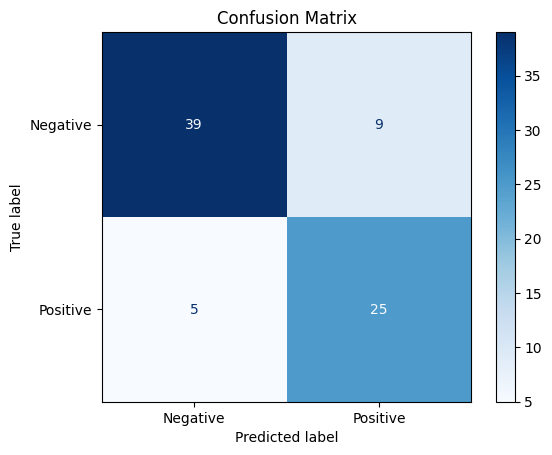


Classification Report:
              precision    recall  f1-score   support

    Negative       0.89      0.81      0.85        48
    Positive       0.74      0.83      0.78        30

    accuracy                           0.82        78
   macro avg       0.81      0.82      0.81        78
weighted avg       0.83      0.82      0.82        78

Number of selected features: 86
Shape of SHAP values: (257, 86)


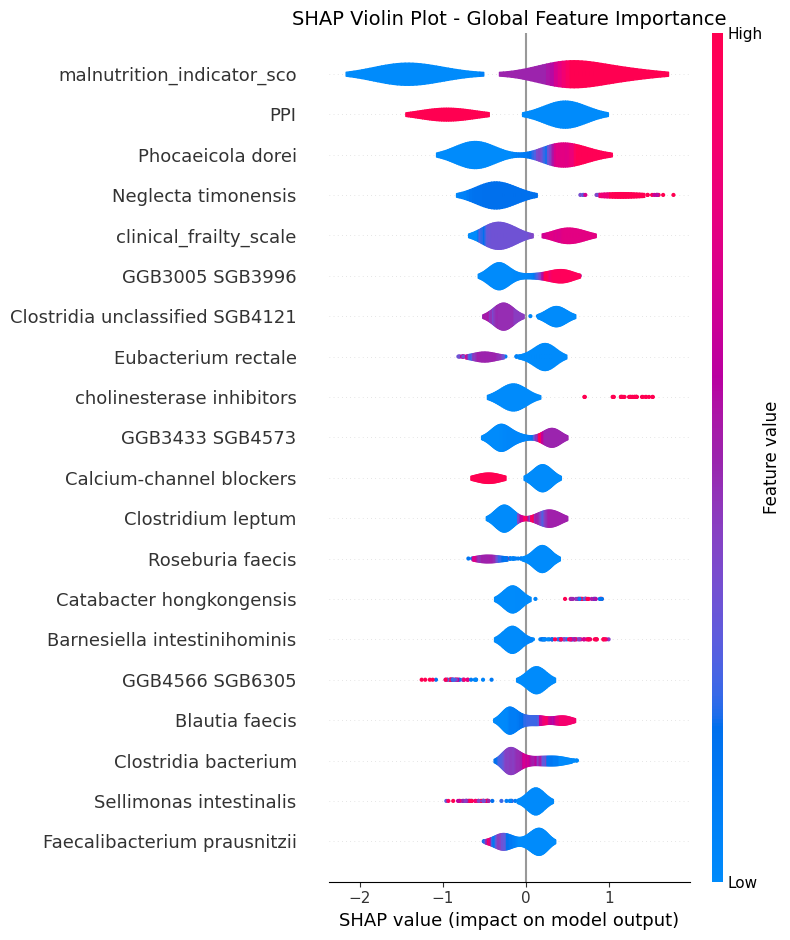

Overlap bacteria found: {'Methanobrevibacter_smithii', 'GGB3256_SGB4303', 'Massilimicrobiota_sp_An134', 'Roseburia_faecis', 'Lachnospiraceae_bacterium', 'Ruthenibacterium_lactatiformans', 'Bacteroides_fragilis', 'Dialister_invisus', 'Dorea_formicigenerans', 'Eubacterium_siraeum', 'Rikenellaceae_bacterium', 'Klebsiella_pneumoniae', 'Phocaeicola_vulgatus', 'Roseburia_hominis', 'Barnesiella_intestinihominis', 'GGB3433_SGB4573', 'Cloacibacillus_evryensis', 'Bacteroides_ovatus', 'Streptococcus_parasanguinis', 'Bacteroides_thetaiotaomicron', 'Clostridium_scindens', 'Blautia_faecis', 'Clostridia_unclassified_SGB4121', 'Lachnospiraceae_unclassified_SGB66069', 'Evtepia_gabavorous', 'Blautia_caecimuris', 'Bacteroides_caccae', 'GGB9557_SGB14966', 'Bacteroides_uniformis', 'Clostridia_bacterium', 'Neglecta_timonensis', 'Alistipes_putredinis', 'GGB3005_SGB3996', 'Prevotella_pectinovora', 'Eubacterium_rectale', 'Clostridia_unclassified_SGB4367', 'Roseburia_inulinivorans', 'Clostridiales_bacterium', '

In [14]:
import optuna
from optuna.samplers import TPESampler
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import (
    roc_curve, roc_auc_score, f1_score, accuracy_score, confusion_matrix, 
    classification_report, ConfusionMatrixDisplay
)

from sklearn.model_selection import StratifiedKFold
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
from sklearn.model_selection import train_test_split
from copy import deepcopy
from sklearn.preprocessing import StandardScaler

# Constants and Configuration
print(f"Experiment number: {experiment_number} | Seed number: {seed}")
# seed = experiment_seed  # Replace with your experiment seed
test_size = 0.25
gpu_device = "hist"

# Function to check for overlaps between train and test data
def check_for_overlap(train_data, test_data):
    """
    Checks for overlapping Sample ID and study_id between train and test datasets.
    """
    # Check for overlapping Study IDs
    overlap_study_ids = set(train_data["study_id"]) & set(test_data["study_id"])
    if overlap_study_ids:
        print(f"Overlap Study ID found: {overlap_study_ids}")
    else:
        print("No overlap Study ID found.")

    # Check for overlapping Sample IDs
    overlap_sample_ids = set(train_data["Sample ID"]) & set(test_data["Sample ID"])
    if overlap_sample_ids:
        print(f"Overlap Sample ID found: {overlap_sample_ids}")
    else:
        print("No overlap Sample ID found.")

def check_for_bacteria(list_a, list_b):
    """
    Checks for overlapping bactertia from list_a and list list_b database and predicted bacteria.
    """
    # Check for overlapping Study IDs
    list_a = [item.replace(" ", "_") for item in list_a]
    list_b = [item.replace(" ", "_") for item in list_b]
    
    overlap_bacteria = set(list_a) & set(list_b)
    if overlap_bacteria:
        print(f"Overlap bacteria found: {overlap_bacteria}")
    else:
        print("No overlap bacteria found.")
    return overlap_bacteria

        
def preprocess_data(df, columns_to_drop, test_size, seed):
    # Split study IDs into train/test sets
    study_labels = df.groupby("study_id")["Alzheimers"].max().reset_index()
    train_ids, test_ids = train_test_split(
        study_labels["study_id"],
        test_size=test_size,
        stratify=study_labels["Alzheimers"],
        random_state=seed,
    )
    
    train_data = df[df["study_id"].isin(train_ids)].copy()
    test_data = df[df["study_id"].isin(test_ids)].copy()

    # Check for overlaps
    check_for_overlap(train_data, test_data)
    
    # Select feature columns
    feature_columns = [col for col in df.columns if col not in columns_to_drop]

    # Convert feature columns to float64 to ensure compatibility
    train_data[feature_columns] = train_data[feature_columns].astype(np.float64)
    test_data[feature_columns] = test_data[feature_columns].astype(np.float64)

    # Normalize the feature columns
    scaler = StandardScaler()
    train_data.loc[:, feature_columns] = scaler.fit_transform(train_data[feature_columns])
    test_data.loc[:, feature_columns] = scaler.transform(test_data[feature_columns])

    return train_data, test_data, feature_columns

# Function to compute class weights
def compute_weights(y_train):
    class_weights = compute_class_weight("balanced", classes=np.unique(y_train), y=y_train)
    scale_pos_weight = class_weights[1] / class_weights[0]
    return scale_pos_weight

# Define Optuna Objective Function
def objective(trial, X_train, y_train, scale_pos_weight, seed):
    print(f"Seed in the model {seed} on Device {device}")
    # Feature selection parameters
    threshold = trial.suggest_categorical('threshold', ['median', 'mean', '0.5*mean', '1.5*mean', 'very_low'])
    max_features = trial.suggest_int('max_features', 1, X_train.shape[1])
    norm_order = trial.suggest_int('norm_order', 1, 2)
    threshold_value = -1e10 if threshold == 'very_low' else threshold

    # Feature selection
    selector = SelectFromModel(
        estimator=XGBClassifier(
            objective='binary:logistic',
            eval_metric='logloss',
            scale_pos_weight= scale_pos_weight,
            random_state=seed,
            tree_method=gpu_device, 
            device=device
        ),
        threshold=threshold_value,
        max_features=max_features,
        norm_order=norm_order
    )
    
    selector.fit(X_train, y_train)
    X_train_selected = selector.transform(X_train)

    # Define XGBoost parameters
    params = {
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.5),
        'max_depth': trial.suggest_int('max_depth', 3, 30),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 10),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 10),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 10),
        'scale_pos_weight': scale_pos_weight,
        'seed': seed,
        'tree_method': gpu_device,
        'device': device
    }

    # Cross-validation
    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=seed)
    f1_scores = []
    for train_idx, val_idx in skf.split(X_train_selected, y_train):
        X_train_fold, X_val_fold = X_train_selected[train_idx], X_train_selected[val_idx]
        y_train_fold, y_val_fold = y_train[train_idx], y_train[val_idx]
        dtrain = xgb.DMatrix(X_train_fold, label=y_train_fold)
        dval = xgb.DMatrix(X_val_fold, label=y_val_fold)
        model = xgb.train(
            params=params,
            dtrain=dtrain,
            num_boost_round=trial.suggest_int("n_estimators", 50, 300),
            evals=[(dtrain, 'train'), (dval, 'eval')],
            early_stopping_rounds=50,
            verbose_eval=False
        )
        y_val_pred = model.predict(dval)
        y_val_pred_binary = (y_val_pred >= 0.5).astype(int)
        f1_scores.append(f1_score(y_val_fold, y_val_pred_binary))
    return np.mean(f1_scores)

# Main Program
columns_to_drop = ["Sample ID", "study_id", "Alzheimers", "Date Sample", "age", "Dementia Other"] # "malnutrition_indicator_sco", "clinical_frailty_scale", "PPI", 

train_data, test_data, feature_columns = preprocess_data(clinical_microbiome_df, columns_to_drop, test_size, seed)
X_train = deepcopy(train_data[feature_columns].values)
y_train = np.array(train_data["Alzheimers"].values)
X_test = deepcopy(test_data[feature_columns].values)
y_test = np.array(test_data["Alzheimers"].values)
scale_pos_weight = compute_weights(y_train)

# Run Optuna Optimization
study = optuna.create_study(direction="maximize", sampler=TPESampler(seed=seed))
study.optimize(lambda trial: objective(trial, X_train, y_train, scale_pos_weight, seed), n_trials=100)

# Best Parameters
best_params = study.best_params
print("Best Parameters:", best_params)

# Apply Final Model
final_selector = SelectFromModel(
    estimator=XGBClassifier(
        objective='binary:logistic',
        eval_metric='logloss',
        random_state=seed,
        tree_method=gpu_device,
        device=device,
        scale_pos_weight=scale_pos_weight
    ),
    
    threshold=-1e10 if best_params['threshold'] == 'very_low' else best_params['threshold'],
    max_features=best_params['max_features'],
    norm_order=best_params['norm_order']
)

final_selector.fit(X_train, y_train)
X_train_selected = final_selector.transform(X_train)
X_test_selected = final_selector.transform(X_test)

# Train Final Model
final_model_params = {
    **{k: v for k, v in best_params.items() if k not in ['threshold', 'norm_order', 'max_features', 'n_estimators']},
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'scale_pos_weight': scale_pos_weight,
    'seed': seed,
    'tree_method': gpu_device,
    'device': device
}

dtrain_final = xgb.DMatrix(X_train_selected, label=y_train)
dtest_final = xgb.DMatrix(X_test_selected)

final_model = xgb.train(
    params=final_model_params,
    dtrain=dtrain_final,
    num_boost_round=best_params['n_estimators'],
)

# Predictions and Evaluation
y_test_pred = final_model.predict(dtest_final)
y_test_pred_binary = (y_test_pred >= 0.5).astype(int)
auc = roc_auc_score(y_test, y_test_pred)
accuracy = accuracy_score(y_test, y_test_pred_binary)
f1 = f1_score(y_test, y_test_pred_binary)
conf_matrix = confusion_matrix(y_test, y_test_pred_binary)

print("\nTest Metrics:")
print(f"ROC AUC: {auc}\nAccuracy: {accuracy}\nF1 Score: {f1}\nConfusion Matrix:\n{conf_matrix}")
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=["Negative", "Positive"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

report = classification_report(y_test, y_test_pred_binary, target_names=["Negative", "Positive"])
print("\nClassification Report:")
print(report)

# Extract feature names for selected features
selected_feature_names = [feature_columns[i] for i in final_selector.get_support(indices=True)]
print(f"Number of selected features: {len(selected_feature_names)}")

# Step 1: Initialize SHAP explainer
explainer = shap.Explainer(final_model, X_train_selected)

# Step 2: Compute SHAP values
shap_values = explainer(X_train_selected, check_additivity=False)

# Ensure SHAP values are in the correct shape for processing
print(f"Shape of SHAP values: {shap_values.values.shape}")  # Check the shape

# Truncate each feature name to a maximum of 30 characters
max_len = 40
selected_feature_names = [
    feature[:max_len] if len(feature) > max_len else feature  # Truncate if longer than 30 characters
    for feature in selected_feature_names
]

# Verify the selected feature names align with the SHAP values
assert len(selected_feature_names) == X_train_selected.shape[1], "Mismatch in feature names and SHAP input dimensions."

# Generate SHAP summary plot with corrected feature names
plt.figure(figsize=(20, 10))  # Increased width for a wider plot
plt.title("SHAP Violin Plot - Global Feature Importance", fontsize=14)

# Create summary plot with corrected feature names
shap.summary_plot(
    shap_values.values,  # SHAP values
    X_train_selected,  # Input data
    feature_names=selected_feature_names,  # Correct feature names
    max_display=20,  # Limit to top 20 features
    plot_type="violin"  # Violin plot with colors
)
plt.show()

bacteria_fount = check_for_bacteria(bacteria_df.species_name.tolist(),selected_feature_names)

In [50]:
train_data["Sample ID"].tolist()

['DC071',
 'DC013',
 'DC019',
 'DC014',
 'DC015',
 'DC016',
 'DC017',
 'DC018',
 'DC020',
 'DC021',
 'DC022',
 'DC072',
 'DC073',
 'DC075',
 'DC074',
 'DC028',
 'DC045',
 'DC046',
 'DC047',
 'DC048',
 'DC049',
 'DC050',
 'DC051',
 'DC052',
 'DC024',
 'DC025',
 'DC026',
 'DC027',
 'DC029',
 'DC030',
 'DC031',
 'DC032',
 'DC033',
 'DC034',
 'DC054',
 'DC055',
 'DC056',
 'DC057',
 'DC058',
 'DC059',
 'DC060',
 'DC061',
 'DC062',
 'DC063',
 'DC064',
 'FB003',
 'DC001',
 'DC002',
 'DC003',
 'DC004',
 'DC005',
 'DC006',
 'DC007',
 'DC008',
 'DC009',
 'DC010',
 'DC011',
 'DC012',
 'DC080',
 'DC081',
 'DC082',
 'DC083',
 'DC084',
 'DC085',
 'DC086',
 'DC087',
 'DC088',
 'DC089',
 'DC090',
 'DC091',
 'DC092',
 'FB014',
 'DC099',
 'FB004',
 'DC102',
 'FB026',
 'FB009',
 'FB033',
 'FB040',
 'FB061',
 'FB031',
 'FB037',
 'FB076',
 'FB079',
 'FB049',
 'FB074',
 'FB039',
 'FB063',
 'FB036',
 'FB054',
 'FB053',
 'FB048',
 'FB058',
 'FB062',
 'FB144',
 'FB146',
 'FB199',
 'FB088',
 'FB110',
 'FB143',


In [26]:
bacteria_fount

{'Alistipes_finegoldii',
 'Alistipes_onderdonkii',
 'Alistipes_putredinis',
 'Anaerobutyricum_hallii',
 'Bacteroides_caccae',
 'Bacteroides_fragilis',
 'Bacteroides_ovatus',
 'Bacteroides_stercoris',
 'Bacteroides_thetaiotaomicron',
 'Bacteroides_uniformis',
 'Bacteroides_xylanisolvens',
 'Barnesiella_intestinihominis',
 'Blautia_caecimuris',
 'Blautia_faecis',
 'Blautia_massiliensis',
 'Candidatus_Avimonas_narfia',
 'Catabacter_hongkongensis',
 'Cloacibacillus_evryensis',
 'Clostridia_bacterium',
 'Clostridia_unclassified_SGB4121',
 'Clostridia_unclassified_SGB4367',
 'Clostridiales_bacterium',
 'Clostridium_leptum',
 'Clostridium_scindens',
 'Clostridium_sp_AF34_10BH',
 'Clostridium_sp_AT4',
 'Clostridium_symbiosum',
 'Collinsella_aerofaciens',
 'Dialister_invisus',
 'Dorea_formicigenerans',
 'Escherichia_coli',
 'Eubacterium_rectale',
 'Eubacterium_siraeum',
 'Evtepia_gabavorous',
 'Faecalibacterium_prausnitzii',
 'Firmicutes_bacterium',
 'GGB3005_SGB3996',
 'GGB3256_SGB4303',
 'GGB

In [15]:
auc

np.float64(0.9125000000000001)

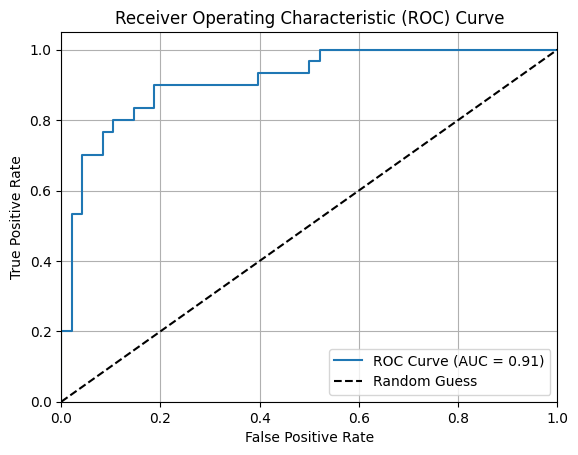

In [16]:
# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_test_pred)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')  # Dashed diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()

In [17]:
accuracy

0.8205128205128205

In [18]:
f1

np.float64(0.78125)

In [19]:
conf_matrix

array([[39,  9],
       [ 5, 25]])

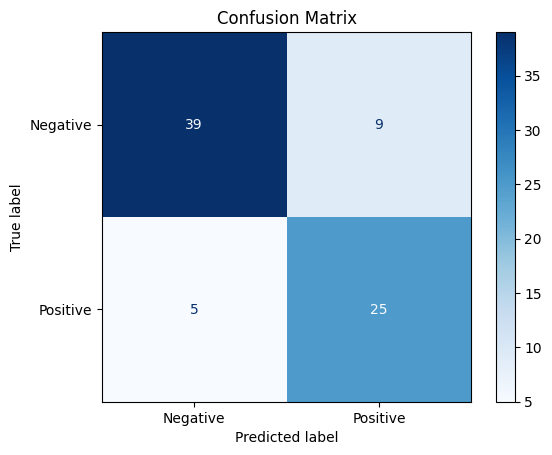

In [20]:
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=["Negative", "Positive"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

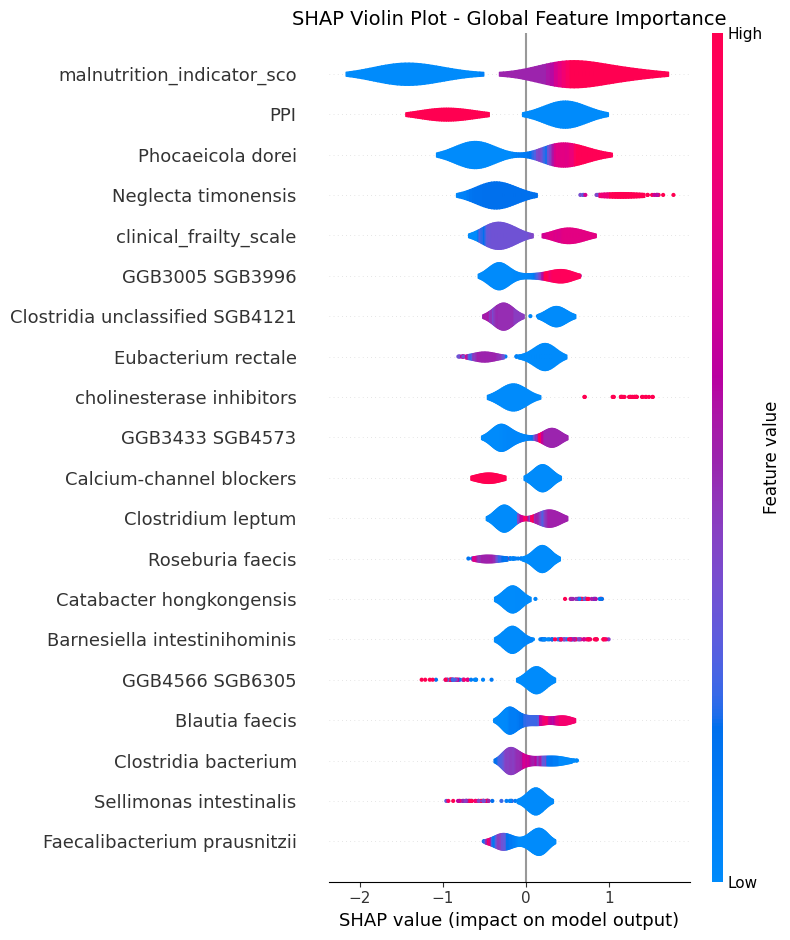

Overlap bacteria found: {'Methanobrevibacter_smithii', 'GGB3256_SGB4303', 'Massilimicrobiota_sp_An134', 'Roseburia_faecis', 'Lachnospiraceae_bacterium', 'Ruthenibacterium_lactatiformans', 'Bacteroides_fragilis', 'Dialister_invisus', 'Dorea_formicigenerans', 'Eubacterium_siraeum', 'Rikenellaceae_bacterium', 'Klebsiella_pneumoniae', 'Phocaeicola_vulgatus', 'Roseburia_hominis', 'Barnesiella_intestinihominis', 'GGB3433_SGB4573', 'Cloacibacillus_evryensis', 'Bacteroides_ovatus', 'Streptococcus_parasanguinis', 'Bacteroides_thetaiotaomicron', 'Clostridium_scindens', 'Blautia_faecis', 'Clostridia_unclassified_SGB4121', 'Lachnospiraceae_unclassified_SGB66069', 'Evtepia_gabavorous', 'Blautia_caecimuris', 'Bacteroides_caccae', 'GGB9557_SGB14966', 'Bacteroides_uniformis', 'Clostridia_bacterium', 'Neglecta_timonensis', 'Alistipes_putredinis', 'GGB3005_SGB3996', 'Prevotella_pectinovora', 'Eubacterium_rectale', 'Clostridia_unclassified_SGB4367', 'Roseburia_inulinivorans', 'Clostridiales_bacterium', '

In [21]:
# Verify the selected feature names align with the SHAP values
assert len(selected_feature_names) == X_train_selected.shape[1], "Mismatch in feature names and SHAP input dimensions."

# Generate SHAP summary plot with corrected feature names
plt.figure(figsize=(20, 10))  # Increased width for a wider plot
plt.title("SHAP Violin Plot - Global Feature Importance", fontsize=14)

# Create summary plot with corrected feature names
shap.summary_plot(
    shap_values.values,  # SHAP values
    X_train_selected,  # Input data
    feature_names=selected_feature_names,  # Correct feature names
    max_display=20,  # Limit to top 20 features
    plot_type="violin"  # Violin plot with colors
)
plt.show()

bacteria_fount = check_for_bacteria(bacteria_df.species_name.tolist(),selected_feature_names)

In [46]:
# Compute directional SHAP statistics
mean_shap = shap_values.values.mean(axis=0)  # Mean SHAP value (directional)
mean_abs_shap = np.abs(shap_values.values).mean(axis=0)  # Mean absolute SHAP value (magnitude)
std_shap = shap_values.values.std(axis=0)  # Standard deviation of SHAP values

# Create a DataFrame summarizing the SHAP values
directional_shap_df = pd.DataFrame({
    "Feature": selected_feature_names,
    "Mean_SHAP": mean_shap,         # Direction
    "Mean_Abs_SHAP": mean_abs_shap, # Magnitude
    "Std_SHAP": std_shap            # Variability
})

# Sort by the magnitude (Mean_Abs_SHAP) in descending order
directional_shap_df = directional_shap_df.sort_values(by="Mean_Abs_SHAP", ascending=False).reset_index(drop=True)

directional_shap_df.to_csv(f"output{os.sep}xgboost_experiment{experiment_number:02d}_shap_values.csv", index=False)

Shape of SHAP values: (257, 86)


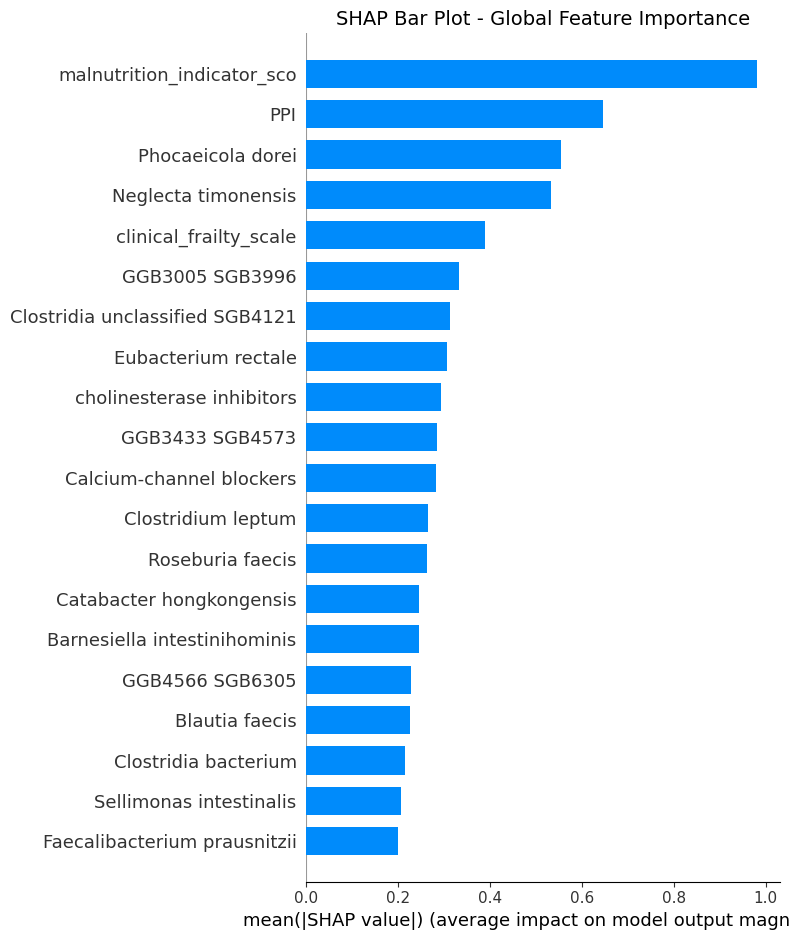

Overlap bacteria found: {'Methanobrevibacter_smithii', 'GGB3256_SGB4303', 'Massilimicrobiota_sp_An134', 'Roseburia_faecis', 'Lachnospiraceae_bacterium', 'Ruthenibacterium_lactatiformans', 'Bacteroides_fragilis', 'Dialister_invisus', 'Dorea_formicigenerans', 'Eubacterium_siraeum', 'Rikenellaceae_bacterium', 'Klebsiella_pneumoniae', 'Phocaeicola_vulgatus', 'Roseburia_hominis', 'Barnesiella_intestinihominis', 'GGB3433_SGB4573', 'Cloacibacillus_evryensis', 'Bacteroides_ovatus', 'Streptococcus_parasanguinis', 'Bacteroides_thetaiotaomicron', 'Clostridium_scindens', 'Blautia_faecis', 'Clostridia_unclassified_SGB4121', 'Lachnospiraceae_unclassified_SGB66069', 'Evtepia_gabavorous', 'Blautia_caecimuris', 'Bacteroides_caccae', 'GGB9557_SGB14966', 'Bacteroides_uniformis', 'Clostridia_bacterium', 'Neglecta_timonensis', 'Alistipes_putredinis', 'GGB3005_SGB3996', 'Prevotella_pectinovora', 'Eubacterium_rectale', 'Clostridia_unclassified_SGB4367', 'Roseburia_inulinivorans', 'Clostridiales_bacterium', '

In [22]:
# Ensure SHAP values are in the correct shape for processing
print(f"Shape of SHAP values: {shap_values.values.shape}")  # Check the shape

# Truncate each feature name to a maximum of 30 characters
max_len = 40
selected_feature_names = [
    feature[:max_len] if len(feature) > max_len else feature  # Truncate if longer than 30 characters
    for feature in selected_feature_names
]

# Verify the selected feature names align with the SHAP values
assert len(selected_feature_names) == X_train_selected.shape[1], "Mismatch in feature names and SHAP input dimensions."

# Generate SHAP summary plot with corrected feature names
plt.figure(figsize=(20, 10))  # Increased width for a wider plot
plt.title("SHAP Bar Plot - Global Feature Importance", fontsize=14)

# Create summary plot with corrected feature names
shap.summary_plot(
    shap_values.values,  # SHAP values
    X_train_selected,  # Input data
    feature_names=selected_feature_names,  # Correct feature names
    max_display=20,  # Limit to top 20 features
    plot_type="bar"  # Violin plot with colors
)
plt.show()

bacteria_fount = check_for_bacteria(bacteria_df.species_name.tolist(),selected_feature_names)

In [23]:
measures = ["xgboost", seed, experiment_number, accuracy, auc, f1]

# Create a DataFrame with appropriate column names
columns = ["Model", "Seed", "Experiment_Number", "Accuracy", "AUC", "F1_Score"]
measures_df = pd.DataFrame([measures], columns=columns)
measures_df

,Model,Seed,Experiment_Number,Accuracy,AUC,F1_Score
0,xgboost,315491657,1,0.820513,0.9125,0.78125


In [24]:
output_path = "output"
measures_path = f"{output_path}{os.sep}xgboost_experiment{experiment_number:02d}_measures.csv"
if output_path and not os.path.exists(output_path):
    os.makedirs(output_path)
measures_path

'output/xgboost_experiment01_measures.csv'

In [25]:
measures_df.to_csv(measures_path, index=False)